# **Coordinate-based method**

## **Labelling algorithm using tree-based ML approaches**

### **Imports and Installs**

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.25.2

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Successfully uninstalled numpy-1.25.2
  Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
blosc2 3.3.4 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.


In [ ]:
!pip uninstall -y catboost
!pip install catboost

^C


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import plotly.graph_objects as go
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import joblib
import json


# from catboost import CatBoostClassifier

import warnings
# Setting the warnings to be ignored
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


### **Google Drive connection**

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Upload files**

In [ ]:
path = '/content/drive/Shared drives/TFGs Coronarias 2024_25/Maren/Data/Skeletonization/Dataframes/'
path_saved = '/content/drive/Shared drives/TFG Maren/Data/ML_results/Coordinate_based'

### **Functions**

In [ ]:
def load_and_combine_data(output_dir, segment_type):
    """
    Loads and combines all CSV files for a given segment type ('rca' or 'lca'),
    keeping the case number and condition (normal or diseased).

    Parameters:
    - output_dir (str): Directory containing the CSV files.
    - segment_type (str): 'rca' or 'lca'.

    Returns:
    - pd.DataFrame: Combined DataFrame with all loaded data, including case number and condition.
    """
    combined_df = pd.DataFrame(columns=["Px", "Py", "Pz", "label", "case", "condition"])  # Add "condition" column

    for file_name in os.listdir(output_dir):
        if file_name.startswith(f"df_{segment_type}_") and file_name.endswith(".csv"):
            file_path = os.path.join(output_dir, file_name)
            df = pd.read_csv(file_path)

            # Extract the case number (e.g., df_rca_n5.csv -> "5", df_lca_d12.csv -> "12")
            case_number = ''.join(filter(str.isdigit, file_name))
            df["case"] = int(case_number)  # Convert to integer

            # Determine the condition (e.g., 'n' -> Normal, 'd' -> Diseased)
            if f"_{segment_type}_n" in file_name:
                condition = "Normal"
            elif f"_{segment_type}_d" in file_name:
                condition = "Diseased"
            else:
                condition = "Unknown"  # Fallback for unexpected cases

            df["condition"] = condition  # Add the condition column

            combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df

In [ ]:
# Preprocessing: Split into features (X) and labels (y)
def preprocess_data(df):
    X = df[["Px", "Py", "Pz"]].values
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df["label"])
    return X, y, label_encoder

In [ ]:
def visualize_predictions(df):
    """
    Visualizes the segmented branches of the artery for each case and condition using a 3D scatter plot.
    Each plot corresponds to a different case and condition, and both the true labels and predicted labels are visualized.

    Parameters:
    df (pd.DataFrame): DataFrame containing artery segments with 'Px', 'Py', 'Pz', 'label', 'prediction', 'case', and 'condition'.
    """
    # Get unique combinations of case and condition
    unique_cases_conditions = df[['case', 'condition']].drop_duplicates()

    for _, row in unique_cases_conditions.iterrows():
        case, condition = row['case'], row['condition']
        case_condition_data = df[(df['case'] == case) & (df['condition'] == condition)]

        # Get unique labels
        true_labels = case_condition_data['label'].unique()
        predicted_labels = case_condition_data['prediction'].unique()

        # Generate color mappings
        true_color_map = dict(zip(true_labels, np.linspace(0, 0.5, len(true_labels))))  # True labels in one color range
        predicted_color_map = dict(zip(predicted_labels, np.linspace(0.5, 1, len(predicted_labels))))  # Predictions in another color range

        fig = go.Figure()

        # Plot true labels
        for label in true_labels:
            label_data = case_condition_data[case_condition_data['label'] == label]
            fig.add_trace(go.Scatter3d(
                x=label_data['Px'],
                y=label_data['Py'],
                z=label_data['Pz'],
                mode='markers',
                marker=dict(size=3, color=true_color_map[label], colorscale='Blues', opacity=0.6),
                name=f'True Label {label}'
            ))

        # Plot predicted labels
        for label in predicted_labels:
            label_data = case_condition_data[case_condition_data['prediction'] == label]
            fig.add_trace(go.Scatter3d(
                x=label_data['Px'],
                y=label_data['Py'],
                z=label_data['Pz'],
                mode='markers',
                marker=dict(size=3, color=predicted_color_map[label], colorscale='Reds', opacity=0.6),
                name=f'Predicted Label {label}'
            ))

        # Configure layout
        fig.update_layout(
            title=f'Predictions vs True Labels for Case {case} ({condition})',
            scene=dict(
                xaxis=dict(title='Px', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
                yaxis=dict(title='Py', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
                zaxis=dict(title='Pz', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
                aspectmode='data'
            ),
            margin=dict(l=10, r=10, b=10, t=50),
            height=800
        )

        fig.show()


In [ ]:
def visualize_case(df, case, condition):
    """
    Visualizes the segmented branches of the artery for a specific case and condition using a 3D scatter plot.
    Both the true labels and predicted labels are visualized.

    Parameters:
    df (pd.DataFrame): DataFrame containing artery segments with 'Px', 'Py', 'Pz', 'label', 'prediction', 'case', and 'condition'.
    case (str or int): The case identifier to visualize.
    condition (str): The condition identifier to visualize.
    """
    # Filter data for the selected case and condition
    case_condition_data = df[(df['case'] == case) & (df['condition'] == condition)]

    if case_condition_data.empty:
        print(f"No data found for case {case} and condition {condition}.")
        return

    # Get unique labels
    true_labels = case_condition_data['label'].unique()
    predicted_labels = case_condition_data['prediction'].unique()

    # Generate color mappings
    true_color_map = dict(zip(true_labels, np.linspace(0, 0.5, len(true_labels))))  # True labels in one color range
    predicted_color_map = dict(zip(predicted_labels, np.linspace(0.5, 1, len(predicted_labels))))  # Predictions in another color range

    fig = go.Figure()

    # Plot true labels
    for label in true_labels:
        label_data = case_condition_data[case_condition_data['label'] == label]
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=3, color=true_color_map[label], colorscale='Blues', opacity=0.6),
            name=f'True Label {label}'
        ))

    # Plot predicted labels
    for label in predicted_labels:
        label_data = case_condition_data[case_condition_data['prediction'] == label]
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=3, color=predicted_color_map[label], colorscale='Reds', opacity=0.6),
            name=f'Predicted Label {label}'
        ))

    # Configure layout
    fig.update_layout(
        title=f'Predictions vs True Labels for Case {case} ({condition})',
        scene=dict(
            xaxis=dict(title='Px', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            yaxis=dict(title='Py', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            zaxis=dict(title='Pz', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            aspectmode='data'
        ),
        margin=dict(l=10, r=10, b=10, t=50),
        height=800
    )

    fig.show()


In [ ]:
def visualize_case(df, case, condition):
    """
    Visualizes the segmented branches of the artery for a specific case and condition using a 3D scatter plot.
    Both the true labels and predicted labels are visualized.

    Parameters:
    df (pd.DataFrame): DataFrame containing artery segments with 'Px', 'Py', 'Pz', 'label', 'prediction', 'case', and 'condition'.
    case (str or int): The case identifier to visualize.
    condition (str): The condition identifier to visualize.
    """
    # Define the mapping of labels to branch names
    branch_name_map = {
        1: "1 - pRCA",
        2: "2 - mRCA",
        3: "3 - dRCA",
        4: "4 - R-PDA",
        5: "5 - LM",
        6: "6 - pLAD",
        7: "7 - mLAD",
        8: "8 - dLAD",
        9: "9 - D1",
        10: "10 - D2",
        11: "11 - pLCx",
        12: "12 - OM1",
        13: "13 - LCx",
        14: "14 - OM2",
        15: "15 - L-PDA",
        16: "16 - R-PLB",
        17: "17 - RI",
        18: "18 - L-PLB"
    }

    # Filter data for the selected case and condition
    case_condition_data = df[(df['case'] == case) & (df['condition'] == condition)]

    if case_condition_data.empty:
        print(f"No data found for case {case} and condition {condition}.")
        return

    # Get unique labels
    true_labels = case_condition_data['label'].unique()
    predicted_labels = case_condition_data['prediction'].unique()

    # Generate color mappings
    true_color_map = dict(zip(true_labels, np.linspace(0, 0.5, len(true_labels))))
    predicted_color_map = dict(zip(predicted_labels, np.linspace(0.5, 1, len(predicted_labels))))

    fig = go.Figure()

    # Plot true labels
    for label in true_labels:
        label_data = case_condition_data[case_condition_data['label'] == label]
        label_name = branch_name_map.get(label, f'Label {label}')
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=3, color=true_color_map[label], colorscale='Blues', opacity=0.6),
            name=f'True {label_name}'
        ))

    # Plot predicted labels
    for label in predicted_labels:
        label_data = case_condition_data[case_condition_data['prediction'] == label]
        label_name = branch_name_map.get(label, f'Label {label}')
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=3, color=predicted_color_map[label], colorscale='Reds', opacity=0.6),
            name=f'Predicted {label_name}'
        ))

    # Configure layout
    fig.update_layout(
        title=f'Predictions vs True Labels for Case {case} ({condition})',
        scene=dict(
            xaxis=dict(title='Px', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            yaxis=dict(title='Py', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            zaxis=dict(title='Pz', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            aspectmode='data'
        ),
        margin=dict(l=10, r=10, b=10, t=50),
        height=800
    )

    fig.show()

In [ ]:
def plot_classification_report_heatmap(y_true, y_pred, label_encoder, figsize=(12, 8)):
    """
    Generate and visualize a classification report as a heatmap.

    Parameters:
    - y_true (array-like): True labels of the test set.
    - y_pred (array-like): Predicted labels of the test set.
    - label_encoder (LabelEncoder): The label encoder used to encode the labels.
    - figsize (tuple): Size of the figure for the heatmap.

    Returns:
    - None: Displays the heatmap.
    """
    # Generate the classification report as a dictionary
    report_dict = classification_report(
        y_true,
        y_pred,
        target_names=label_encoder.classes_.astype(str),
        output_dict=True
    )

    # Convert the classification report to a DataFrame
    report_df = pd.DataFrame(report_dict).transpose()

    # Visualize the report using a heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        report_df.iloc[:-1, :-1],  # Exclude 'accuracy' row and support column
        annot=True,
        cmap="coolwarm",  # More vibrant color palette
        cbar=True,
        fmt=".2f",
        linewidths=1,
        linecolor='white',  # White lines to separate cells
        annot_kws={"size": 12, "weight": 'bold', "color": 'black'}  # Larger and bold annotation text
    )

    # Set title and labels
    plt.title("Classification Report Heatmap", fontsize=16, weight='bold')
    plt.ylabel("Classes", fontsize=14)
    plt.xlabel("\nMetrics", fontsize=14)

    # Rotate axis labels for better readability
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
def save_simple_model(model, model_name, artery_type, df_test, y_true, y_pred, label_encoder, base_path):
    """
    Guarda el modelo, predicciones (DataFrame), accuracy y classification_report (TXT).
    """
    save_dir = os.path.join(base_path, artery_type, model_name)
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    joblib.dump(model, os.path.join(save_dir, f"{model_name}_model.pkl"))

    # Save predictions DataFrame
    df_test.to_csv(os.path.join(save_dir, f"{model_name}_predictions.csv"), index=False)

    # Save classification report TXT
    report_text = classification_report(y_true, y_pred, target_names=label_encoder.classes_.astype(str))
    with open(os.path.join(save_dir, f"{model_name}_report.txt"), 'w') as f:
        f.write(report_text)

    # Save accuracy in a .txt file
    accuracy = accuracy_score(y_true, y_pred)
    with open(os.path.join(save_dir, f"{model_name}_accuracy.txt"), 'w') as f:
        f.write(f"Accuracy: {accuracy:.4f}")

    print(f"✅ Saved model, predictions, report, and accuracy for {model_name} - {artery_type}")

    return accuracy

In [ ]:
def load_simple_model(model_name, artery_type, base_path):
    """
    Carga el modelo, las predicciones, el classification report y el accuracy.

    Devuelve:
    - model: El modelo entrenado (scikit-learn)
    - df_predictions: DataFrame de predicciones
    - classification_report_text: El classification report en formato string (como lo da sklearn)
    - accuracy: Accuracy como float
    """
    load_dir = os.path.join(base_path, artery_type, model_name)

    # Load model
    model = joblib.load(os.path.join(load_dir, f"{model_name}_model.pkl"))

    # Load predictions DataFrame
    df_predictions = pd.read_csv(os.path.join(load_dir, f"{model_name}_predictions.csv"))

    # Load classification report
    with open(os.path.join(load_dir, f"{model_name}_report.txt"), 'r') as f:
        classification_report_text = f.read()

    # Load accuracy
    with open(os.path.join(load_dir, f"{model_name}_accuracy.txt"), 'r') as f:
        accuracy_line = f.read().strip()
        accuracy = float(accuracy_line.split(":")[1])

    print(f"✅ Loaded model, predictions, report, and accuracy for {model_name} - {artery_type}")

    return model, df_predictions, classification_report_text, accuracy

In [ ]:
# new visualization
def visualize_case(df, case, condition):
    """
    Visualizes the segmented branches of the artery for a specific case and condition using a 3D scatter plot.
    Both the true labels and predicted labels are visualized using the defined color schemes.
    """
    # Filtrar por caso y condición
    case_condition_data = df[(df['case'] == case) & (df['condition'] == condition)]

    if case_condition_data.empty:
        print(f"No data found for case {case} and condition {condition}.")
        return

    fig = go.Figure()

    # Etiquetas reales
    for label in case_condition_data['label'].unique():
        label_data = case_condition_data[case_condition_data['label'] == label]
        color = SEGMENT_COLORS.get(label, 'grey')
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=4, color=color, opacity=0.8),
            name=f'True Label {label}'
        ))

    # Etiquetas predichas
    for label in case_condition_data['prediction'].unique():
        label_data = case_condition_data[case_condition_data['prediction'] == label]
        color = SEGMENT_COLORS.get(label, 'grey')
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=4, color=color, opacity=0.4, symbol='circle'),
            name=f'Predicted Label {label}'
        ))

    fig.update_layout(
        title=f'Predictions vs True Labels for Case {case} ({condition})',
        scene=dict(
            xaxis=dict(title='Px', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            yaxis=dict(title='Py', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            zaxis=dict(title='Pz', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            aspectmode='data'
        ),
        margin=dict(l=10, r=10, b=10, t=50),
        height=800,
        showlegend=True
    )

    fig.show()


### **Tree-based Machine Learning Models**

#### **RCA labeling**

In [ ]:
# Load data
df_rca = load_and_combine_data(path, segment_type="rca")

# Split train/test ensuring cases remain in the same set within each condition
df_rca_train_list = []
df_rca_test_list = []

for condition in df_rca["condition"].unique():
    df_condition = df_rca[df_rca["condition"] == condition]
    unique_cases = df_condition["case"].unique()
    train_cases, test_cases = train_test_split(unique_cases, test_size=0.3, random_state=42)

    df_rca_train_list.append(df_condition[df_condition["case"].isin(train_cases)])
    df_rca_test_list.append(df_condition[df_condition["case"].isin(test_cases)])

# Concatenate train and test dataframes
df_rca_train = pd.concat(df_rca_train_list).copy()
df_rca_test = pd.concat(df_rca_test_list).copy()

# Extract features and labels
X_rca_train, y_rca_train = df_rca_train[["Px", "Py", "Pz"]].values, df_rca_train["label"].values
X_rca_test, y_rca_test = df_rca_test[["Px", "Py", "Pz"]].values, df_rca_test["label"].values

# Standardize features
scaler = StandardScaler()
X_rca_train = scaler.fit_transform(X_rca_train)
X_rca_test = scaler.transform(X_rca_test)

# Encode labels
label_encoder_rca = LabelEncoder()
y_rca_train = label_encoder_rca.fit_transform(y_rca_train)
y_rca_test = label_encoder_rca.transform(y_rca_test)

In [ ]:
df_rca

,Px,Py,Pz,label,case,condition
0,85.907307,76.754954,90.3125,1,1,Normal
1,85.907307,77.586986,90.9375,1,1,Normal
2,86.323323,77.170970,90.9375,1,1,Normal
3,86.323323,78.003002,91.5625,1,1,Normal
4,86.739339,78.419018,91.5625,1,1,Normal
...,...,...,...,...,...,...
15032,128.266569,177.219682,47.1875,16,20,Diseased
15033,128.737272,177.690385,46.5625,16,20,Diseased
15034,129.207975,177.690385,46.5625,16,20,Diseased
15035,129.678678,177.690385,45.9375,16,20,Diseased


##### **Random Forest**

###### Training

In [ ]:
# Train Random Forest classifier
print("Training Random Forest Classifier on RCA...")
rf_rca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_rca.fit(X_rca_train, y_rca_train)

# Make predictions on the test set
y_rca_pred_rf = rf_rca.predict(X_rca_test)

df_rca_test_rf = df_rca_test.copy()
df_rca_test_rf["prediction"] = label_encoder_rca.inverse_transform(y_rca_pred_rf)
df_rca_test_rf

Training Random Forest Classifier on RCA...


,Px,Py,Pz,label,case,condition,prediction
0,85.907307,76.754954,90.3125,1,1,Normal,1
1,85.907307,77.586986,90.9375,1,1,Normal,1
2,86.323323,77.170970,90.9375,1,1,Normal,1
3,86.323323,78.003002,91.5625,1,1,Normal,1
4,86.739339,78.419018,91.5625,1,1,Normal,1
...,...,...,...,...,...,...,...
13481,192.638571,146.935470,49.6875,16,18,Diseased,16
13482,193.095602,144.193284,48.4375,16,18,Diseased,16
13483,193.095602,144.650315,48.4375,16,18,Diseased,16
13484,193.552633,143.279222,48.4375,16,18,Diseased,16


###### Classification Report

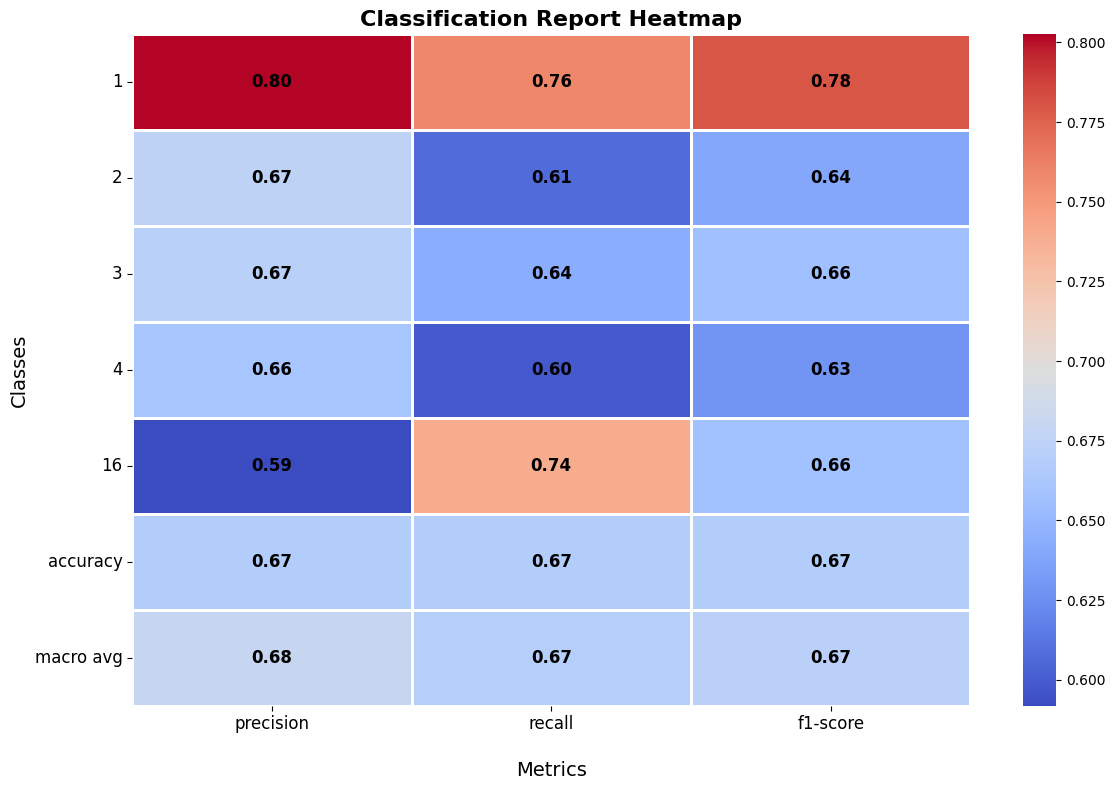

In [ ]:
plot_classification_report_heatmap(y_rca_test, y_rca_pred_rf, label_encoder_rca)

###### Visualization

In [ ]:
visualize_case(df_rca_test_rf, 1, 'Normal')

In [ ]:
# visualize_predictions(df_rca_test_rf)

###### Graph information

In [ ]:
# Características Útiles para Añadir
# Distancias Relativas:

# Distancia al origen: Distancia euclidiana desde el punto al primer nodo del árbol.

# Distancia a la raíz del segmento: Longitud acumulativa a lo largo del camino desde el nodo raíz del segmento.

# Distancia a bifurcaciones: Distancia al nodo de bifurcación más cercano.

# Propiedades de Conexión:

# Número de vecinos: Número de puntos conectados al nodo actual.

# Profundidad en el árbol: Número de pasos desde la raíz del árbol al nodo actual.

# Curvaturas y Ángulos:

# Ángulo entre segmentos: Ángulo entre el vector formado por el punto actual y sus vecinos anterior y posterior.

# Curvatura local: Cambios en la dirección en un radio definido.

# Contexto Topológico:

# Identificador del subárbol: Asocia cada punto con un subárbol o rama específica.

# Etiqueta de bifurcación: Marca si un punto es una bifurcación o un extremo.

In [ ]:
# import pandas as pd
# import numpy as np
# import networkx as nx
# from scipy.spatial import distance_matrix

# def calculate_mst(df):
#     # Extract the coordinates of the points
#     positions = df[['Px', 'Py', 'Pz']].values

#     # Calculate the Euclidean distance matrix between all points
#     dist_matrix = distance_matrix(positions, positions)

#     # Create a graph with all nodes and distances as weights
#     G = nx.Graph()
#     num_nodes = len(positions)
#     for i in range(num_nodes):
#         for j in range(i + 1, num_nodes):
#             G.add_edge(i, j, weight=dist_matrix[i, j])

#     # Get the Minimum Spanning Tree (MST)
#     MST = nx.minimum_spanning_tree(G)
#     return MST

# def extract_mst_features(mst):
#     # Compute total weight of MST
#     total_weight = mst.size(weight='weight')

#     # Compute degree statistics
#     degrees = [deg for _, deg in mst.degree()]
#     avg_degree = np.mean(degrees)

#     # Compute weight statistics
#     weights = [d['weight'] for _, _, d in mst.edges(data=True)]
#     weight_mean = np.mean(weights)
#     weight_std = np.std(weights)

#     # Number of nodes and edges
#     num_nodes = mst.number_of_nodes()
#     num_edges = mst.number_of_edges()

#     # Return as a dictionary
#     return {
#         'total_weight': total_weight,
#         'avg_degree': avg_degree,
#         'weight_mean': weight_mean,
#         'weight_std': weight_std,
#         'num_nodes': num_nodes,
#         'num_edges': num_edges
#     }

# def generate_features_from_mst(df):
#     features = []

#     for case_id, group in df.groupby('case'):
#         mst = calculate_mst(group)
#         mst_features = extract_mst_features(mst)
#         mst_features['case'] = case_id
#         features.append(mst_features)

#     return pd.DataFrame(features)


In [ ]:
# # Load data
# df_all = load_and_combine_data(path, segment_type="rca")

# # Calcular características del MST para todos los casos
# features_df = generate_features_from_mst(df_all)

# # Split train/test ensuring cases remain in the same set within each condition
# df_train_list = []
# df_test_list = []

# for condition in df_all["condition"].unique():
#     df_condition = df_all[df_all["condition"] == condition]
#     unique_cases = df_condition["case"].unique()
#     train_cases, test_cases = train_test_split(unique_cases, test_size=0.3, random_state=42)

#     df_train_list.append(df_condition[df_condition["case"].isin(train_cases)])
#     df_test_list.append(df_condition[df_condition["case"].isin(test_cases)])

# # Concatenate train and test dataframes
# df_train = pd.concat(df_train_list).copy()
# df_test = pd.concat(df_test_list).copy()

# # Añadir características calculadas del MST a los datos de train y test
# features_train = features_df[features_df['case'].isin(df_train['case'].unique())]
# features_test = features_df[features_df['case'].isin(df_test['case'].unique())]

# # Combinar las características del MST con las coordenadas
# X_train = pd.merge(df_train, features_train, on=['case', 'condition'], how='left')
# X_test = pd.merge(df_test, features_test, on=['case', 'condition'], how='left')

# # Separar características y etiquetas
# y_train = X_train["label"].values
# y_test = X_test["label"].values

# # Eliminar columnas no numéricas o irrelevantes para el modelo
# X_train = X_train.drop(columns=["label", "case", "condition"])
# X_test = X_test.drop(columns=["label", "case", "condition"])

# # Standardize features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Encode labels
# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# y_test = label_encoder.transform(y_test)

# ##### **Random Forest**

# ###### Training

# # Train Random Forest classifier
# print("Training Random Forest Classifier...")
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred_rf = rf.predict(X_test)

# # Decode predictions back to original labels
# df_test_rf = df_test.copy()
# df_test_rf["prediction"] = label_encoder.inverse_transform(y_pred_rf)

# ###### Classification Report

# plot_classification_report_heatmap(y_test, y_pred_rf, label_encoder)

# ###### Visualization

# # Visualización de un caso específico
# visualize_case(df_test_rf, case_id=1, condition='Normal')

# # Visualización global de predicciones
# # visualize_predictions(df_test_rf)


##### **Gradient Boosting**

###### Training

In [ ]:
# Train Gradient Boosting classifier
print("Training Gradient Boosting Classifier on RCA...")
gb_rca = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_rca.fit(X_rca_train, y_rca_train)

# Make predictions on the test set
y_rca_pred_gb = gb_rca.predict(X_rca_test)

df_rca_test_gb = df_rca_test.copy()
df_rca_test_gb["prediction"] = label_encoder_rca.inverse_transform(y_rca_pred_gb)
df_rca_test_gb

Training Gradient Boosting Classifier on RCA...


,Px,Py,Pz,label,case,condition,prediction
0,85.907307,76.754954,90.3125,1,1,Normal,1
1,85.907307,77.586986,90.9375,1,1,Normal,1
2,86.323323,77.170970,90.9375,1,1,Normal,1
3,86.323323,78.003002,91.5625,1,1,Normal,1
4,86.739339,78.419018,91.5625,1,1,Normal,1
...,...,...,...,...,...,...,...
13481,192.638571,146.935470,49.6875,16,18,Diseased,16
13482,193.095602,144.193284,48.4375,16,18,Diseased,16
13483,193.095602,144.650315,48.4375,16,18,Diseased,16
13484,193.552633,143.279222,48.4375,16,18,Diseased,16


###### Classification Report

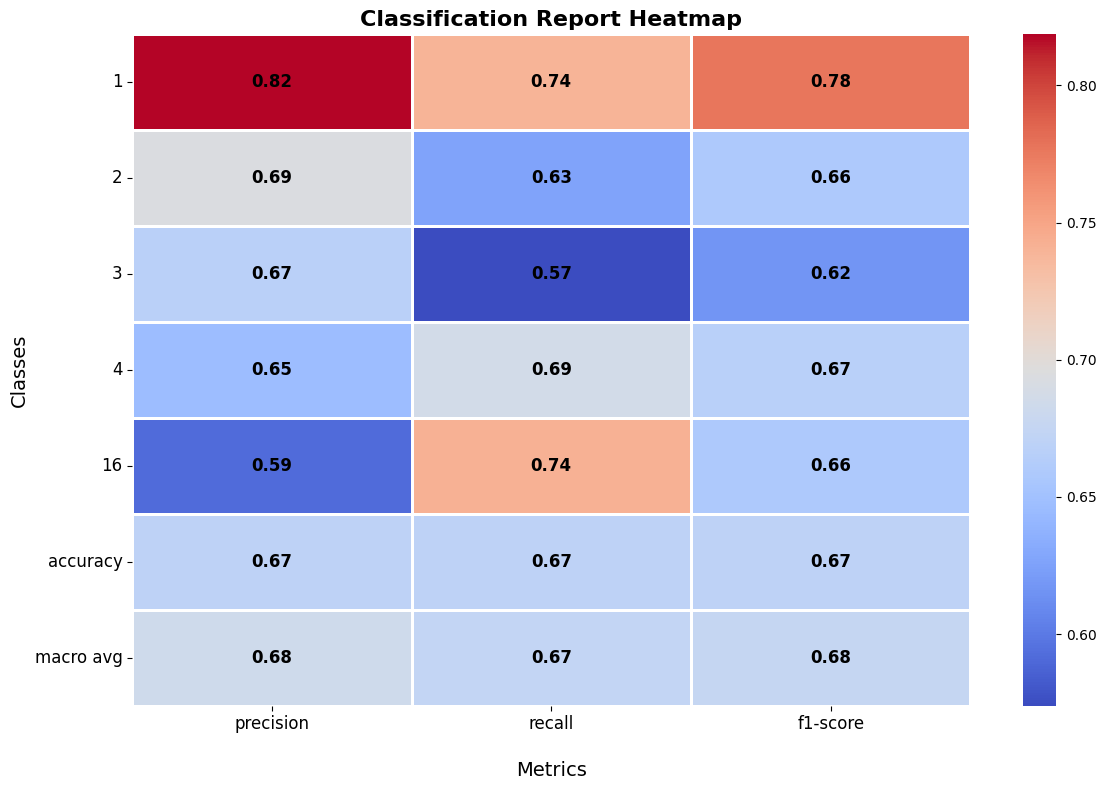

In [ ]:
plot_classification_report_heatmap(y_rca_test, y_rca_pred_gb, label_encoder_rca)

###### Visualization

In [ ]:
visualize_case(df_rca_test_gb, 1, 'Normal')

In [ ]:
# visualize_predictions(df_rca_test_gb)

##### **Extra Trees**

###### Training

In [ ]:
# Train Extra Trees classifier
print("Training Extra Trees Classifier on RCA...")
et_rca = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_rca.fit(X_rca_train, y_rca_train)

# Make predictions on the test set
y_rca_pred_et = et_rca.predict(X_rca_test)

df_rca_test_et = df_rca_test.copy()
df_rca_test_et["prediction"] = label_encoder_rca.inverse_transform(y_rca_pred_et)
df_rca_test_et

Training Extra Trees Classifier on RCA...


,Px,Py,Pz,label,case,condition,prediction
0,85.907307,76.754954,90.3125,1,1,Normal,1
1,85.907307,77.586986,90.9375,1,1,Normal,1
2,86.323323,77.170970,90.9375,1,1,Normal,1
3,86.323323,78.003002,91.5625,1,1,Normal,1
4,86.739339,78.419018,91.5625,1,1,Normal,1
...,...,...,...,...,...,...,...
13481,192.638571,146.935470,49.6875,16,18,Diseased,16
13482,193.095602,144.193284,48.4375,16,18,Diseased,16
13483,193.095602,144.650315,48.4375,16,18,Diseased,16
13484,193.552633,143.279222,48.4375,16,18,Diseased,16


###### Classification Report

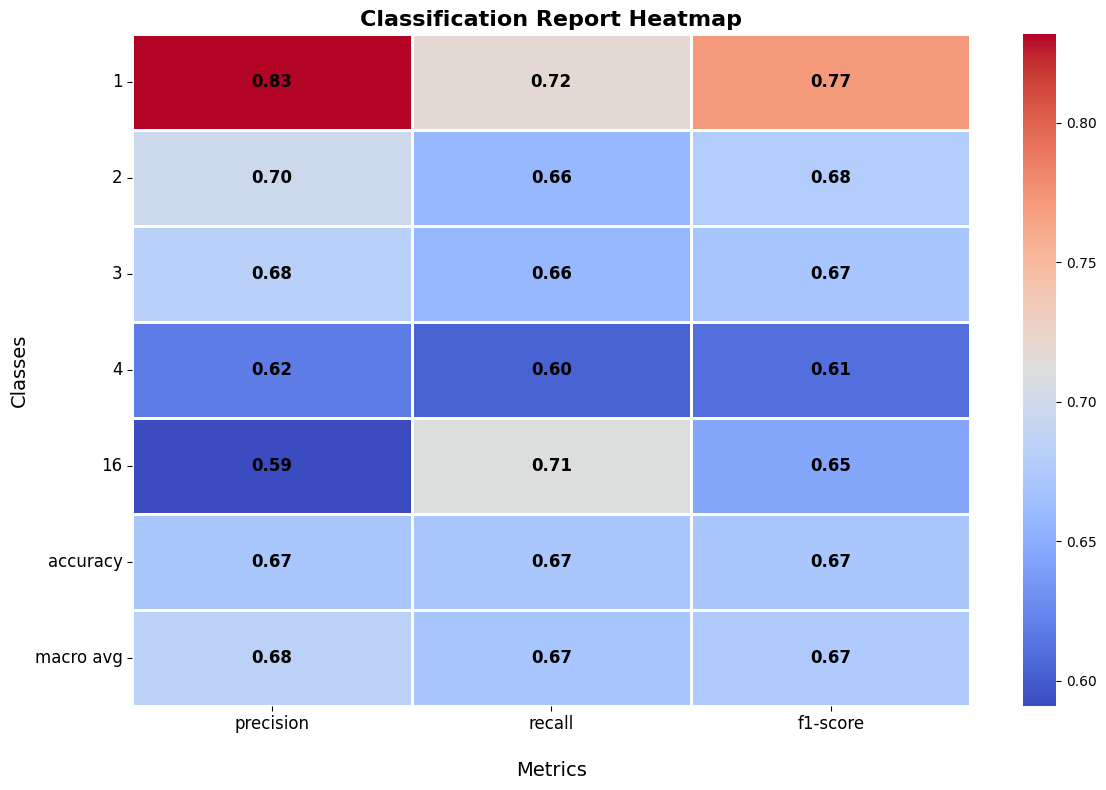

In [ ]:
plot_classification_report_heatmap(y_rca_test, y_rca_pred_et, label_encoder_rca)

###### Visualization

In [ ]:
visualize_case(df_rca_test_et, 1, 'Normal')

In [ ]:
# visualize_predictions(df_rca_test_et)

##### **XGBoost**

###### Training

In [ ]:
# Train XGBoost classifier
print("Training XGBoost Classifier on RCA...")
xgb_rca = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_rca.fit(X_rca_train, y_rca_train)

# Make predictions on the test set
y_rca_pred_xgb = xgb_rca.predict(X_rca_test)

df_rca_test_xgb = df_rca_test.copy()
df_rca_test_xgb["prediction"] = label_encoder_rca.inverse_transform(y_rca_pred_xgb)
df_rca_test_xgb

Training XGBoost Classifier on RCA...


,Px,Py,Pz,label,case,condition,prediction
0,85.907307,76.754954,90.3125,1,1,Normal,1
1,85.907307,77.586986,90.9375,1,1,Normal,1
2,86.323323,77.170970,90.9375,1,1,Normal,1
3,86.323323,78.003002,91.5625,1,1,Normal,1
4,86.739339,78.419018,91.5625,1,1,Normal,1
...,...,...,...,...,...,...,...
13481,192.638571,146.935470,49.6875,16,18,Diseased,16
13482,193.095602,144.193284,48.4375,16,18,Diseased,16
13483,193.095602,144.650315,48.4375,16,18,Diseased,16
13484,193.552633,143.279222,48.4375,16,18,Diseased,16


###### Classification Report

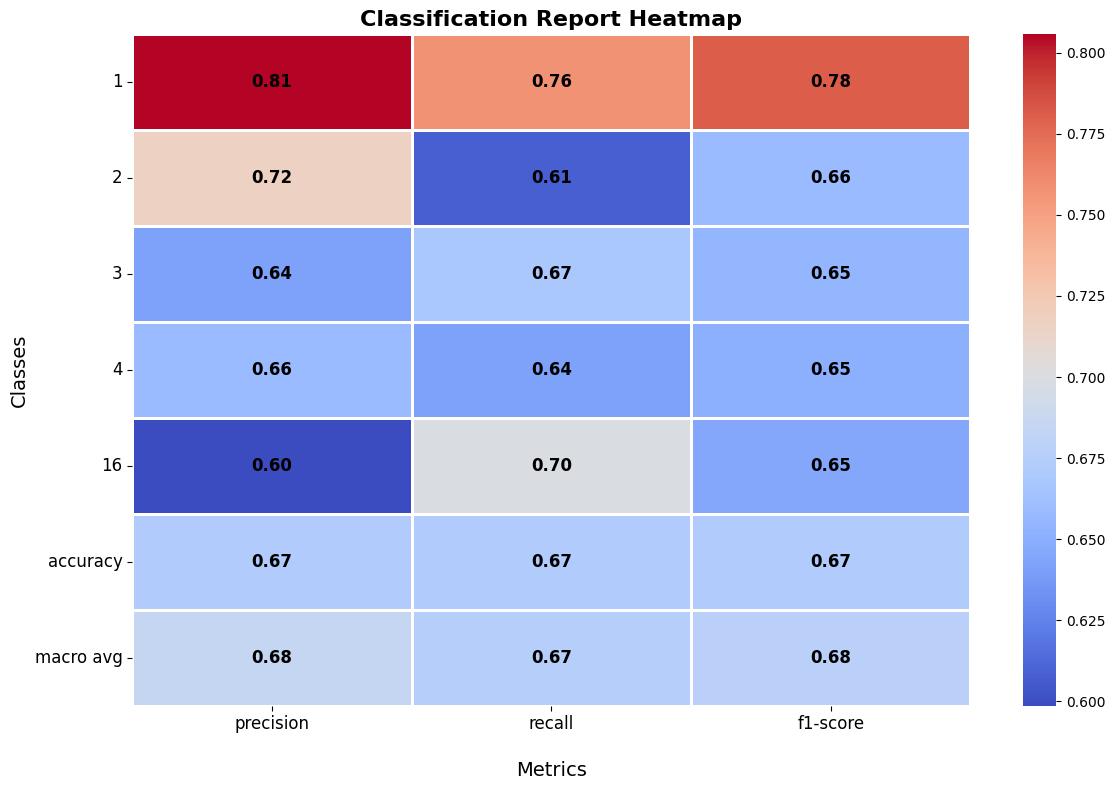

In [ ]:
plot_classification_report_heatmap(y_rca_test, y_rca_pred_xgb, label_encoder_rca)

###### Visualization

In [ ]:
visualize_case(df_rca_test_xgb, 1, 'Normal')

In [ ]:
# visualize_predictions(df_rca_test_xgb)

##### **Decision Tree**

###### Training

In [ ]:
# Train Decision Tree classifier
print("Training Decision Tree Classifier on RCA...")
dt_rca = DecisionTreeClassifier(random_state=42)
dt_rca.fit(X_rca_train, y_rca_train)

# Make predictions on the test set
y_rca_pred_dt = dt_rca.predict(X_rca_test)

df_rca_test_dt = df_rca_test.copy()
df_rca_test_dt["prediction"] = label_encoder_rca.inverse_transform(y_rca_pred_dt)
df_rca_test_dt

Training Decision Tree Classifier on RCA...


,Px,Py,Pz,label,case,condition,prediction
0,85.907307,76.754954,90.3125,1,1,Normal,1
1,85.907307,77.586986,90.9375,1,1,Normal,1
2,86.323323,77.170970,90.9375,1,1,Normal,1
3,86.323323,78.003002,91.5625,1,1,Normal,1
4,86.739339,78.419018,91.5625,1,1,Normal,1
...,...,...,...,...,...,...,...
13481,192.638571,146.935470,49.6875,16,18,Diseased,16
13482,193.095602,144.193284,48.4375,16,18,Diseased,16
13483,193.095602,144.650315,48.4375,16,18,Diseased,16
13484,193.552633,143.279222,48.4375,16,18,Diseased,16


###### Classification Report

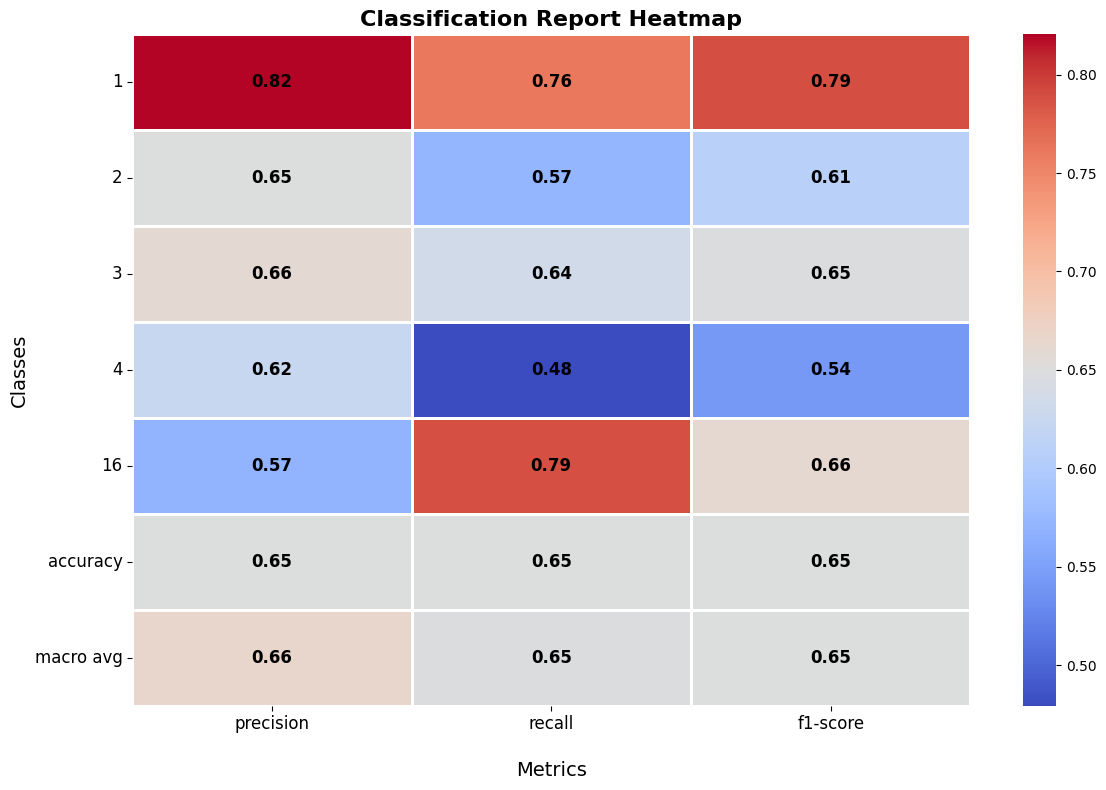

In [ ]:
plot_classification_report_heatmap(y_rca_test, y_rca_pred_dt, label_encoder_rca)

###### Visualization

In [ ]:
visualize_case(df_rca_test_dt, 1, 'Normal')

In [ ]:
# visualize_predictions(df_rca_test_dt)

##### **AdaBoost**

###### Training

In [ ]:
# Train AdaBoost classifier
print("Training AdaBoost Classifier on RCA...")
ab_rca = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_rca.fit(X_rca_train, y_rca_train)

# Make predictions on the test set
y_rca_pred_ab = ab_rca.predict(X_rca_test)

df_rca_test_ab = df_rca_test.copy()
df_rca_test_ab["prediction"] = label_encoder_rca.inverse_transform(y_rca_pred_ab)
df_rca_test_ab

Training AdaBoost Classifier on RCA...


,Px,Py,Pz,label,case,condition,prediction
0,85.907307,76.754954,90.3125,1,1,Normal,1
1,85.907307,77.586986,90.9375,1,1,Normal,1
2,86.323323,77.170970,90.9375,1,1,Normal,1
3,86.323323,78.003002,91.5625,1,1,Normal,1
4,86.739339,78.419018,91.5625,1,1,Normal,1
...,...,...,...,...,...,...,...
13481,192.638571,146.935470,49.6875,16,18,Diseased,4
13482,193.095602,144.193284,48.4375,16,18,Diseased,4
13483,193.095602,144.650315,48.4375,16,18,Diseased,4
13484,193.552633,143.279222,48.4375,16,18,Diseased,4


###### Classification Report

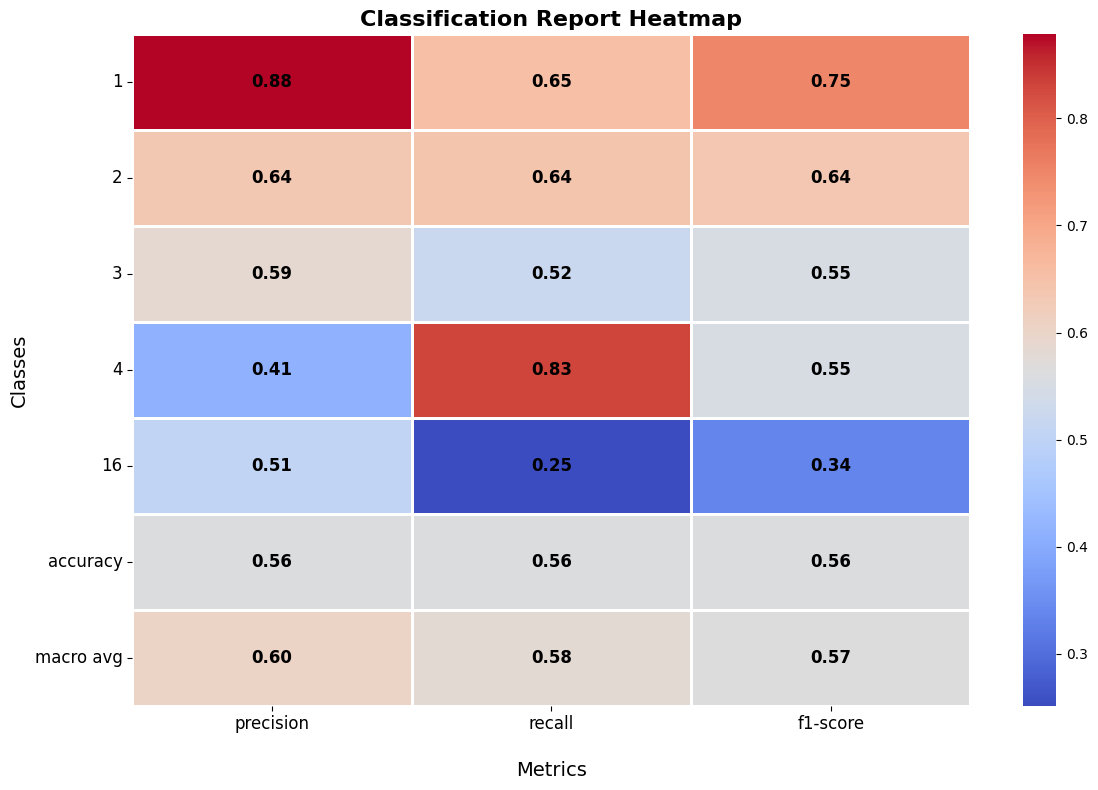

In [ ]:
plot_classification_report_heatmap(y_rca_test, y_rca_pred_ab, label_encoder_rca)

###### Visualization

In [ ]:
visualize_case(df_rca_test_ab, 1, 'Normal')

In [ ]:
# visualize_predictions(df_rca_test_ab)

##### **LightGBM**

###### Training

In [ ]:
# Train LightGBM classifier
print("Training LightGBM Classifier on RCA...")
lgb_rca = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_rca.fit(X_rca_train, y_rca_train)

# Make predictions on the test set
y_rca_pred_lgb = lgb_rca.predict(X_rca_test)

df_rca_test_lgb = df_rca_test.copy()
df_rca_test_lgb["prediction"] = label_encoder_rca.inverse_transform(y_rca_pred_lgb)
df_rca_test_lgb

Training LightGBM Classifier on RCA...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 10425, number of used features: 3
[LightGBM] [Info] Start training from score -1.893768
[LightGBM] [Info] Start training from score -1.488091
[LightGBM] [Info] Start training from score -1.607043
[LightGBM] [Info] Start training from score -1.587615
[LightGBM] [Info] Start training from score -1.519593


,Px,Py,Pz,label,case,condition,prediction
0,85.907307,76.754954,90.3125,1,1,Normal,1
1,85.907307,77.586986,90.9375,1,1,Normal,1
2,86.323323,77.170970,90.9375,1,1,Normal,1
3,86.323323,78.003002,91.5625,1,1,Normal,1
4,86.739339,78.419018,91.5625,1,1,Normal,1
...,...,...,...,...,...,...,...
13481,192.638571,146.935470,49.6875,16,18,Diseased,16
13482,193.095602,144.193284,48.4375,16,18,Diseased,16
13483,193.095602,144.650315,48.4375,16,18,Diseased,16
13484,193.552633,143.279222,48.4375,16,18,Diseased,16


###### Classification Report

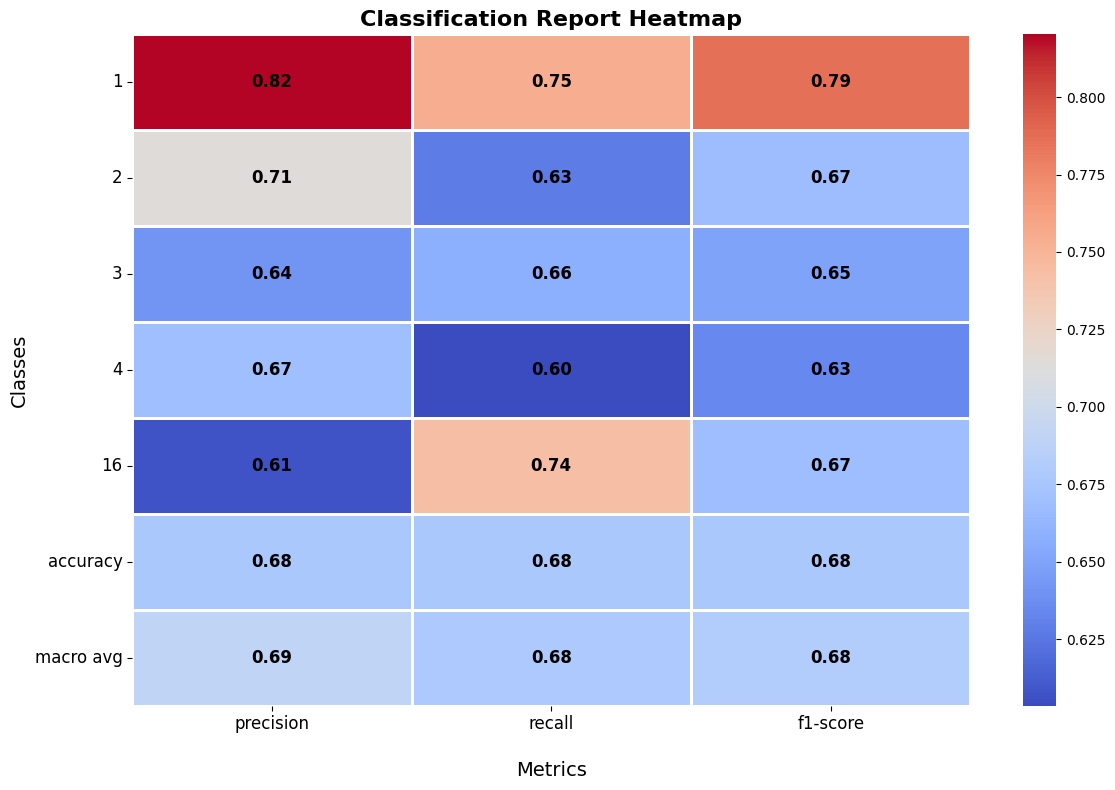

In [ ]:
plot_classification_report_heatmap(y_rca_test, y_rca_pred_lgb, label_encoder_rca)

###### Visualization

In [ ]:
visualize_case(df_rca_test_lgb, 1, 'Normal')

In [ ]:
# visualize_predictions(df_rca_test_lgb)

##### **CatBoost**

###### Training

In [ ]:
# Train CatBoost classifier
print("Training CatBoost Classifier on RCA...")
cb_rca = CatBoostClassifier(iterations=100, random_state=42, silent=True)
cb_rca.fit(X_rca_train, y_rca_train)

# Make predictions on the test set
y_rca_pred_cb = cb_rca.predict(X_rca_test)

df_rca_test_cb = df_rca_test.copy()
df_rca_test_cb["prediction"] = label_encoder_rca.inverse_transform(y_rca_pred_cb)
df_rca_test_cb

Training CatBoost Classifier on RCA...


,Px,Py,Pz,label,case,condition,prediction
0,85.907307,76.754954,90.3125,1,1,Normal,1
1,85.907307,77.586986,90.9375,1,1,Normal,1
2,86.323323,77.170970,90.9375,1,1,Normal,1
3,86.323323,78.003002,91.5625,1,1,Normal,1
4,86.739339,78.419018,91.5625,1,1,Normal,1
...,...,...,...,...,...,...,...
13481,192.638571,146.935470,49.6875,16,18,Diseased,16
13482,193.095602,144.193284,48.4375,16,18,Diseased,16
13483,193.095602,144.650315,48.4375,16,18,Diseased,16
13484,193.552633,143.279222,48.4375,16,18,Diseased,16


###### Classification Report

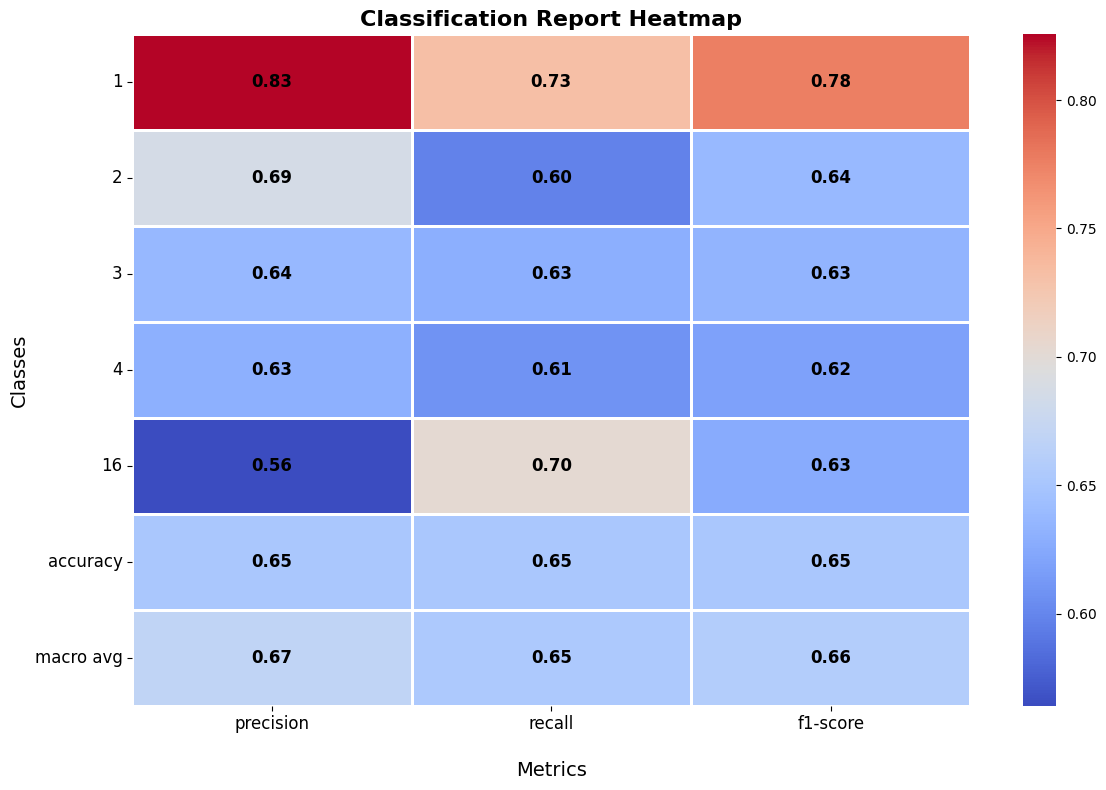

In [ ]:
plot_classification_report_heatmap(y_rca_test, y_rca_pred_cb, label_encoder_rca)

###### Visualization

In [ ]:
visualize_case(df_rca_test_cb, 1, 'Normal')

In [ ]:
# visualize_predictions(df_rca_test_cb)

##### **HistGradientBoosting**

###### Training

In [ ]:
# Train HistGradientBoosting classifier
print("Training HistGradientBoosting Classifier on RCA...")
hgb_rca = HistGradientBoostingClassifier(max_iter=100, random_state=42)
hgb_rca.fit(X_rca_train, y_rca_train)

# Make predictions on the test set
y_rca_pred_hgb = hgb_rca.predict(X_rca_test)

df_rca_test_hgb = df_rca_test.copy()
df_rca_test_hgb["prediction"] = label_encoder_rca.inverse_transform(y_rca_pred_hgb)
df_rca_test_hgb

Training HistGradientBoosting Classifier on RCA...


,Px,Py,Pz,label,case,condition,prediction
0,85.907307,76.754954,90.3125,1,1,Normal,1
1,85.907307,77.586986,90.9375,1,1,Normal,1
2,86.323323,77.170970,90.9375,1,1,Normal,1
3,86.323323,78.003002,91.5625,1,1,Normal,1
4,86.739339,78.419018,91.5625,1,1,Normal,1
...,...,...,...,...,...,...,...
13481,192.638571,146.935470,49.6875,16,18,Diseased,16
13482,193.095602,144.193284,48.4375,16,18,Diseased,16
13483,193.095602,144.650315,48.4375,16,18,Diseased,16
13484,193.552633,143.279222,48.4375,16,18,Diseased,16


###### Classification Report

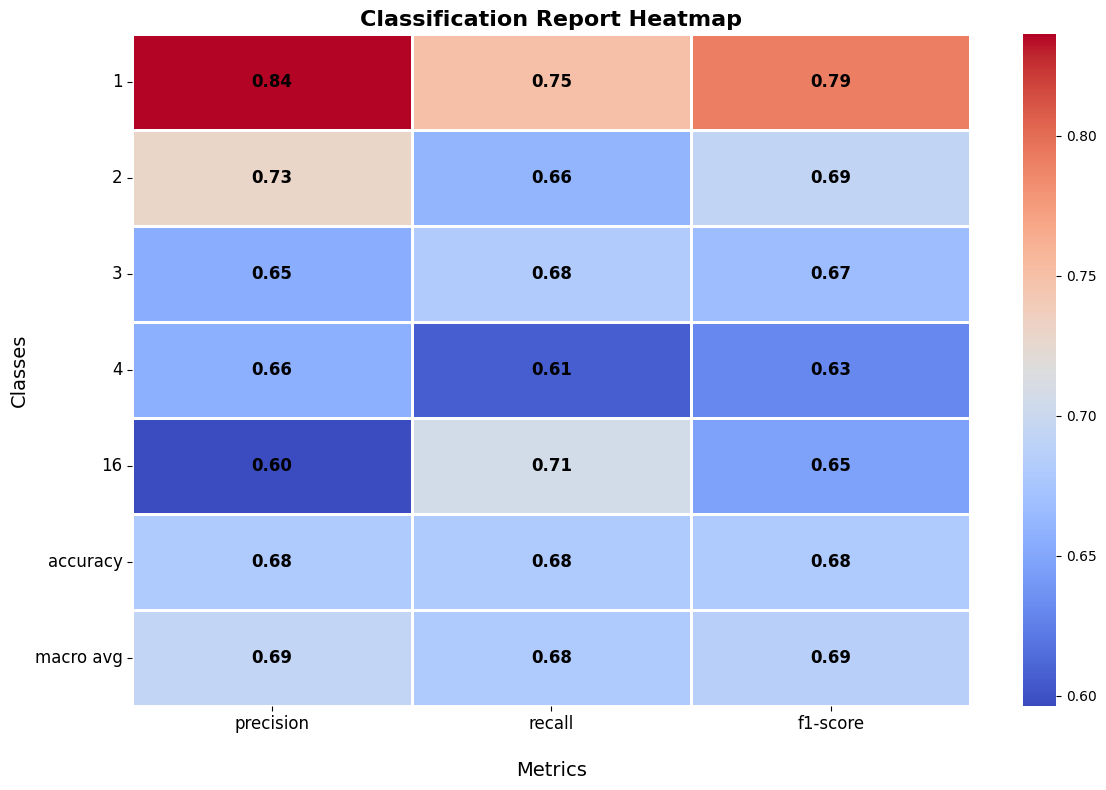

In [ ]:
plot_classification_report_heatmap(y_rca_test, y_rca_pred_hgb, label_encoder_rca)

###### Visualization

In [ ]:
visualize_case(df_rca_test_hgb, 1, 'Normal')

In [ ]:
# visualize_predictions(df_rca_test_hgb)

##### **Save and Load**

In [ ]:
# RCA - RandomForest
accuracy_rf = save_simple_model(rf_rca, "RandomForest", "RCA", df_rca_test_rf, y_rca_test, y_rca_pred_rf, label_encoder_rca, path_saved)
model_rf, df_preds_rf, report_rf, accuracy_rf = load_simple_model("RandomForest", "RCA", path_saved)
print(report_rf); print(f"Accuracy: {accuracy_rf:.4f}")

# RCA - GradientBoosting
accuracy_gb = save_simple_model(gb_rca, "GradientBoosting", "RCA", df_rca_test_gb, y_rca_test, y_rca_pred_gb, label_encoder_rca, path_saved)
model_gb, df_preds_gb, report_gb, accuracy_gb = load_simple_model("GradientBoosting", "RCA", path_saved)
print(report_gb); print(f"Accuracy: {accuracy_gb:.4f}")

# RCA - ExtraTrees
accuracy_et = save_simple_model(et_rca, "ExtraTrees", "RCA", df_rca_test_et, y_rca_test, y_rca_pred_et, label_encoder_rca, path_saved)
model_et, df_preds_et, report_et, accuracy_et = load_simple_model("ExtraTrees", "RCA", path_saved)
print(report_et); print(f"Accuracy: {accuracy_et:.4f}")

# RCA - XGBoost
accuracy_xgb = save_simple_model(xgb_rca, "XGBoost", "RCA", df_rca_test_xgb, y_rca_test, y_rca_pred_xgb, label_encoder_rca, path_saved)
model_xgb, df_preds_xgb, report_xgb, accuracy_xgb = load_simple_model("XGBoost", "RCA", path_saved)
print(report_xgb); print(f"Accuracy: {accuracy_xgb:.4f}")

# RCA - DecisionTree
accuracy_dt = save_simple_model(dt_rca, "DecisionTree", "RCA", df_rca_test_dt, y_rca_test, y_rca_pred_dt, label_encoder_rca, path_saved)
model_dt, df_preds_dt, report_dt, accuracy_dt = load_simple_model("DecisionTree", "RCA", path_saved)
print(report_dt); print(f"Accuracy: {accuracy_dt:.4f}")

# RCA - AdaBoost
accuracy_ab = save_simple_model(ab_rca, "AdaBoost", "RCA", df_rca_test_ab, y_rca_test, y_rca_pred_ab, label_encoder_rca, path_saved)
model_ab, df_preds_ab, report_ab, accuracy_ab = load_simple_model("AdaBoost", "RCA", path_saved)
print(report_ab); print(f"Accuracy: {accuracy_ab:.4f}")

# RCA - LightGBM
accuracy_lgb = save_simple_model(lgb_rca, "LightGBM", "RCA", df_rca_test_lgb, y_rca_test, y_rca_pred_lgb, label_encoder_rca, path_saved)
model_lgb, df_preds_lgb, report_lgb, accuracy_lgb = load_simple_model("LightGBM", "RCA", path_saved)
print(report_lgb); print(f"Accuracy: {accuracy_lgb:.4f}")

# RCA - CatBoost
accuracy_cb = save_simple_model(cb_rca, "CatBoost", "RCA", df_rca_test_cb, y_rca_test, y_rca_pred_cb, label_encoder_rca, path_saved)
model_cb, df_preds_cb, report_cb, accuracy_cb = load_simple_model("CatBoost", "RCA", path_saved)
print(report_cb); print(f"Accuracy: {accuracy_cb:.4f}")

# RCA - HistGradientBoosting
accuracy_hgb = save_simple_model(hgb_rca, "HistGradientBoosting", "RCA", df_rca_test_hgb, y_rca_test, y_rca_pred_hgb, label_encoder_rca, path_saved)
model_hgb, df_preds_hgb, report_hgb, accuracy_hgb = load_simple_model("HistGradientBoosting", "RCA", path_saved)
print(report_hgb); print(f"Accuracy: {accuracy_hgb:.4f}")

✅ Saved model, predictions, report, and accuracy for RandomForest - RCA
✅ Loaded model, predictions, report, and accuracy for RandomForest - RCA
              precision    recall  f1-score   support

           1       0.80      0.76      0.78       750
           2       0.67      0.61      0.64       990
           3       0.67      0.64      0.66      1028
           4       0.66      0.60      0.63       807
          16       0.59      0.74      0.66      1037

    accuracy                           0.67      4612
   macro avg       0.68      0.67      0.67      4612
weighted avg       0.67      0.67      0.67      4612

Accuracy: 0.6680
✅ Saved model, predictions, report, and accuracy for GradientBoosting - RCA
✅ Loaded model, predictions, report, and accuracy for GradientBoosting - RCA
              precision    recall  f1-score   support

           1       0.82      0.74      0.78       750
           2       0.69      0.63      0.66       990
           3       0.67      0.57

#### **LCA labeling**

In [ ]:
# Load data
df_lca = load_and_combine_data(path, segment_type="lca")

# Split train/test ensuring cases remain in the same set within each condition
df_lca_train_list = []
df_lca_test_list = []

for condition in df_lca["condition"].unique():
    df_condition = df_lca[df_lca["condition"] == condition]
    unique_cases = df_condition["case"].unique()
    train_cases, test_cases = train_test_split(unique_cases, test_size=0.3, random_state=42)

    df_lca_train_list.append(df_condition[df_condition["case"].isin(train_cases)])
    df_lca_test_list.append(df_condition[df_condition["case"].isin(test_cases)])

# Concatenate train and test dataframes
df_lca_train = pd.concat(df_lca_train_list).copy()
df_lca_test = pd.concat(df_lca_test_list).copy()

# Extract features and labels
X_lca_train, y_lca_train = df_lca_train[["Px", "Py", "Pz"]].values, df_lca_train["label"].values
X_lca_test, y_lca_test = df_lca_test[["Px", "Py", "Pz"]].values, df_lca_test["label"].values

# Standardize features
scaler = StandardScaler()
X_lca_train = scaler.fit_transform(X_lca_train)
X_lca_test = scaler.transform(X_lca_test)

# Encode labels
label_encoder_lca = LabelEncoder()
y_lca_train = label_encoder_lca.fit_transform(y_lca_train)
y_lca_test = label_encoder_lca.transform(y_lca_test)

##### **Random Forest**

###### Training

In [ ]:
# Train Random Forest classifier
print("Training Random Forest Classifier on LCA...")
rf_lca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_lca.fit(X_lca_train, y_lca_train)

# Make predictions on the test set
y_lca_pred_rf = rf_lca.predict(X_lca_test)

df_lca_test_rf = df_lca_test.copy()
df_lca_test_rf["prediction"] = label_encoder_lca.inverse_transform(y_lca_pred_rf)
df_lca_test_rf

Training Random Forest Classifier on LCA...


,Px,Py,Pz,label,case,condition,prediction
0,105.460059,122.932732,105.9375,5,1,Normal,11
1,105.876075,123.348748,105.9375,5,1,Normal,11
2,106.292091,123.348748,106.5625,5,1,Normal,11
3,106.708107,123.348748,106.5625,5,1,Normal,11
4,107.124123,123.348748,107.1875,5,1,Normal,11
...,...,...,...,...,...,...,...
23172,169.787021,146.935470,117.8125,17,18,Diseased,9
23173,170.244052,146.935470,117.8125,17,18,Diseased,9
23174,170.701083,146.935470,117.1875,17,18,Diseased,9
23175,171.158114,147.392501,117.1875,17,18,Diseased,9


###### Classification Report

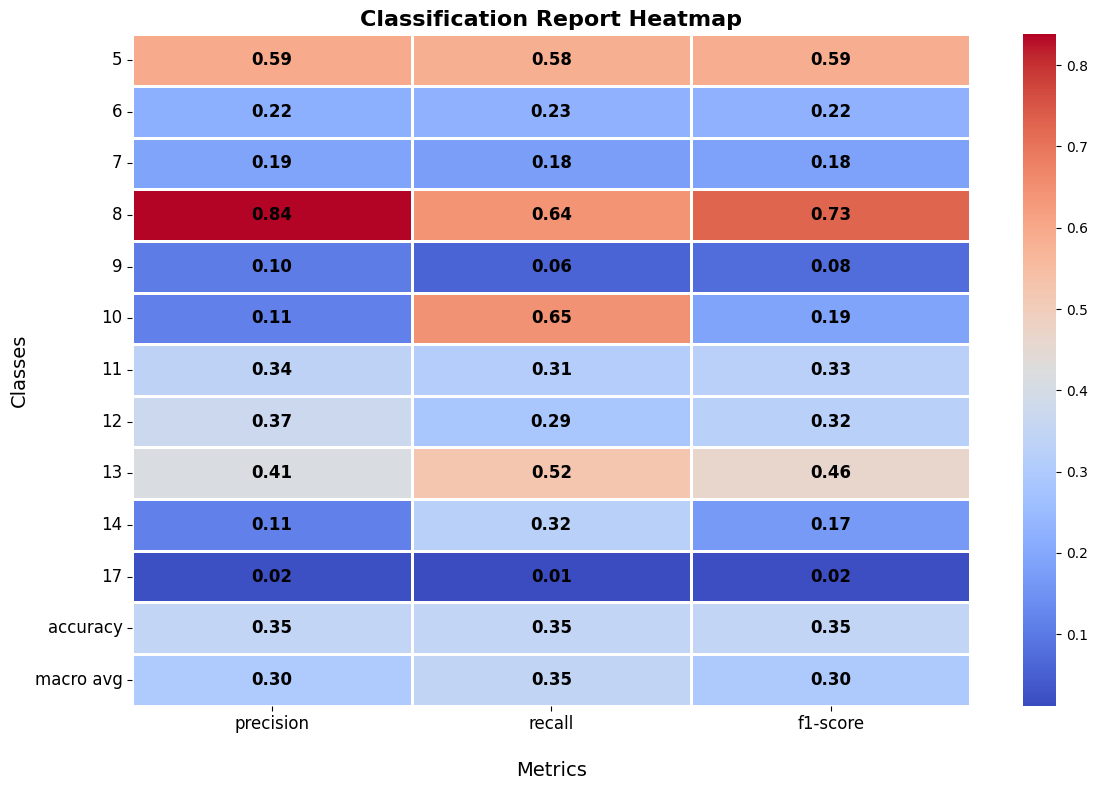

In [ ]:
plot_classification_report_heatmap(y_lca_test, y_lca_pred_rf, label_encoder_lca)

###### Visualization

In [ ]:
visualize_case(df_lca_test_rf, 1, 'Normal')

In [ ]:
# visualize_predictions(df_lca_test_rf)

##### **Gradient Boosting**

###### Training

In [ ]:
# Train Gradient Boosting classifier
print("Training Gradient Boosting Classifier on LCA...")
gb_lca = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_lca.fit(X_lca_train, y_lca_train)

# Make predictions on the test set
y_lca_pred_gb = gb_lca.predict(X_lca_test)

df_lca_test_gb = df_lca_test.copy()
df_lca_test_gb["prediction"] = label_encoder_lca.inverse_transform(y_lca_pred_gb)
df_lca_test_gb

Training Gradient Boosting Classifier on LCA...


,Px,Py,Pz,label,case,condition,prediction
0,105.460059,122.932732,105.9375,5,1,Normal,11
1,105.876075,123.348748,105.9375,5,1,Normal,11
2,106.292091,123.348748,106.5625,5,1,Normal,11
3,106.708107,123.348748,106.5625,5,1,Normal,11
4,107.124123,123.348748,107.1875,5,1,Normal,11
...,...,...,...,...,...,...,...
23172,169.787021,146.935470,117.8125,17,18,Diseased,6
23173,170.244052,146.935470,117.8125,17,18,Diseased,6
23174,170.701083,146.935470,117.1875,17,18,Diseased,6
23175,171.158114,147.392501,117.1875,17,18,Diseased,6


###### Classification Report

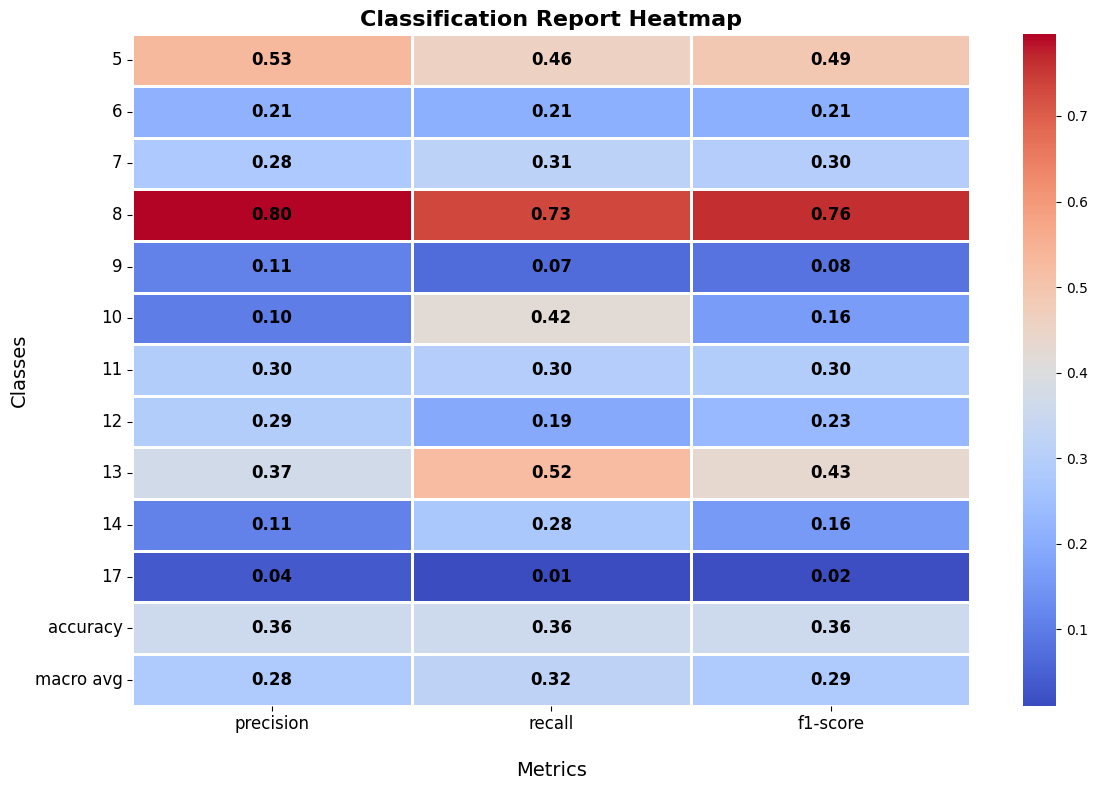

In [ ]:
plot_classification_report_heatmap(y_lca_test, y_lca_pred_gb, label_encoder_lca)

###### Visualization

In [ ]:
visualize_case(df_lca_test_gb, 1, 'Normal')

In [ ]:
# visualize_predictions(df_lca_test_gb)

##### **Extra Trees**

###### Training

In [ ]:
# Train Extra Trees classifier
print("Training Extra Trees Classifier on LCA...")
et_lca = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_lca.fit(X_lca_train, y_lca_train)

# Make predictions on the test set
y_lca_pred_et = et_lca.predict(X_lca_test)

df_lca_test_et = df_lca_test.copy()
df_lca_test_et["prediction"] = label_encoder_lca.inverse_transform(y_lca_pred_et)
df_lca_test_et

Training Extra Trees Classifier on LCA...


,Px,Py,Pz,label,case,condition,prediction
0,105.460059,122.932732,105.9375,5,1,Normal,11
1,105.876075,123.348748,105.9375,5,1,Normal,11
2,106.292091,123.348748,106.5625,5,1,Normal,11
3,106.708107,123.348748,106.5625,5,1,Normal,11
4,107.124123,123.348748,107.1875,5,1,Normal,11
...,...,...,...,...,...,...,...
23172,169.787021,146.935470,117.8125,17,18,Diseased,10
23173,170.244052,146.935470,117.8125,17,18,Diseased,10
23174,170.701083,146.935470,117.1875,17,18,Diseased,10
23175,171.158114,147.392501,117.1875,17,18,Diseased,10


###### Classification Report

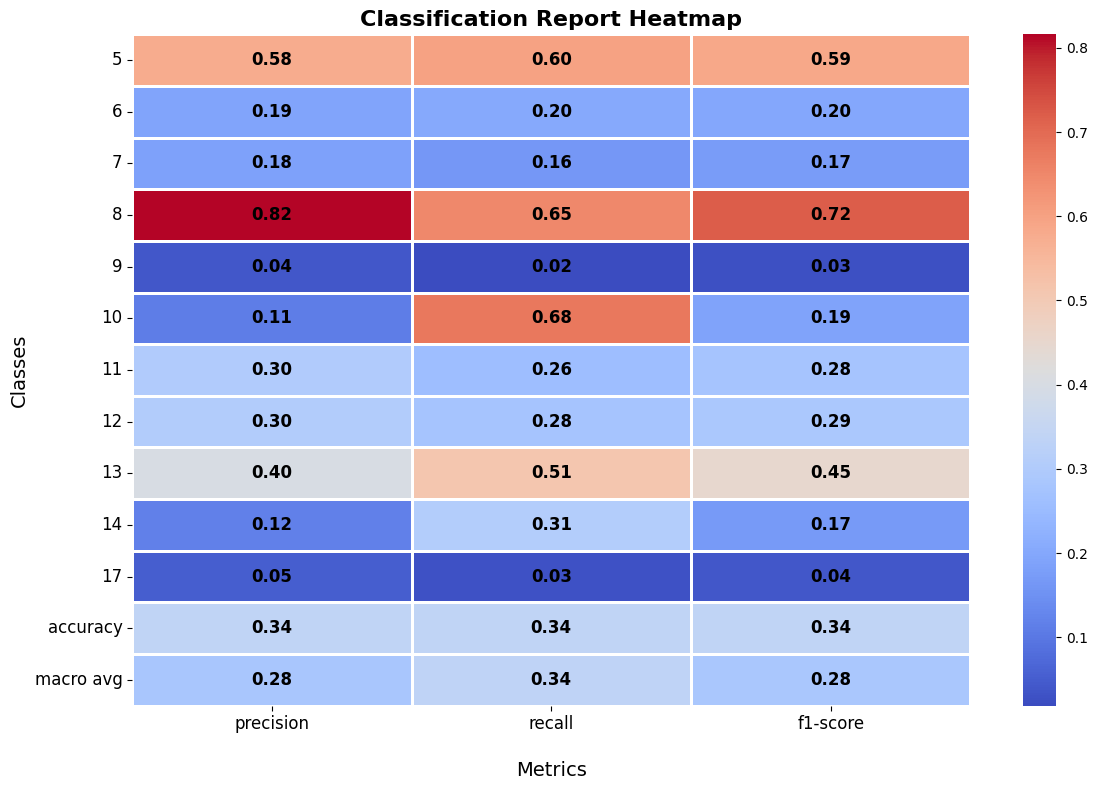

In [ ]:
plot_classification_report_heatmap(y_lca_test, y_lca_pred_et, label_encoder_lca)

###### Visualization

In [ ]:
visualize_case(df_lca_test_et, 1, 'Normal')

In [ ]:
# visualize_predictions(df_lca_test_et)

##### **XGBoost**

###### Training

In [ ]:
# Train XGBoost classifier
print("Training XGBoost Classifier on LCA...")
xgb_lca = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_lca.fit(X_lca_train, y_lca_train)

# Make predictions on the test set
y_lca_pred_xgb = xgb_lca.predict(X_lca_test)

df_lca_test_xgb = df_lca_test.copy()
df_lca_test_xgb["prediction"] = label_encoder_lca.inverse_transform(y_lca_pred_xgb)
df_lca_test_xgb

Training XGBoost Classifier on LCA...


,Px,Py,Pz,label,case,condition,prediction
0,105.460059,122.932732,105.9375,5,1,Normal,11
1,105.876075,123.348748,105.9375,5,1,Normal,11
2,106.292091,123.348748,106.5625,5,1,Normal,11
3,106.708107,123.348748,106.5625,5,1,Normal,11
4,107.124123,123.348748,107.1875,5,1,Normal,11
...,...,...,...,...,...,...,...
23172,169.787021,146.935470,117.8125,17,18,Diseased,6
23173,170.244052,146.935470,117.8125,17,18,Diseased,6
23174,170.701083,146.935470,117.1875,17,18,Diseased,6
23175,171.158114,147.392501,117.1875,17,18,Diseased,6


###### Classification Report

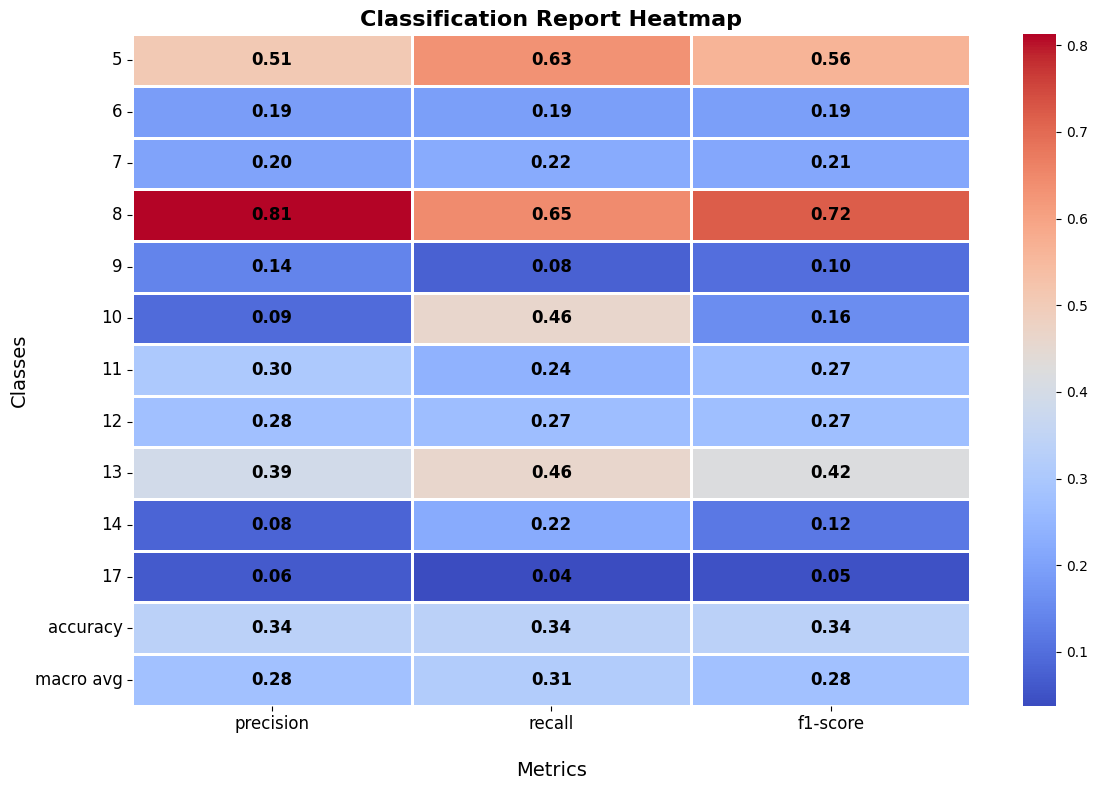

In [ ]:
plot_classification_report_heatmap(y_lca_test, y_lca_pred_xgb, label_encoder_lca)

###### Visualization

In [ ]:
visualize_case(df_lca_test_xgb, 1, 'Normal')

In [ ]:
# visualize_predictions(df_lca_test_xgb)

##### **Decision Tree**

###### Training

In [ ]:
# Train Decision Tree classifier
print("Training Decision Tree Classifier on LCA...")
dt_lca = DecisionTreeClassifier(random_state=42)
dt_lca.fit(X_lca_train, y_lca_train)

# Make predictions on the test set
y_lca_pred_dt = dt_lca.predict(X_lca_test)

df_lca_test_dt = df_lca_test.copy()
df_lca_test_dt["prediction"] = label_encoder_lca.inverse_transform(y_lca_pred_dt)
df_lca_test_dt

Training Decision Tree Classifier on LCA...


,Px,Py,Pz,label,case,condition,prediction
0,105.460059,122.932732,105.9375,5,1,Normal,11
1,105.876075,123.348748,105.9375,5,1,Normal,11
2,106.292091,123.348748,106.5625,5,1,Normal,11
3,106.708107,123.348748,106.5625,5,1,Normal,11
4,107.124123,123.348748,107.1875,5,1,Normal,11
...,...,...,...,...,...,...,...
23172,169.787021,146.935470,117.8125,17,18,Diseased,7
23173,170.244052,146.935470,117.8125,17,18,Diseased,7
23174,170.701083,146.935470,117.1875,17,18,Diseased,7
23175,171.158114,147.392501,117.1875,17,18,Diseased,7


###### Classification Report

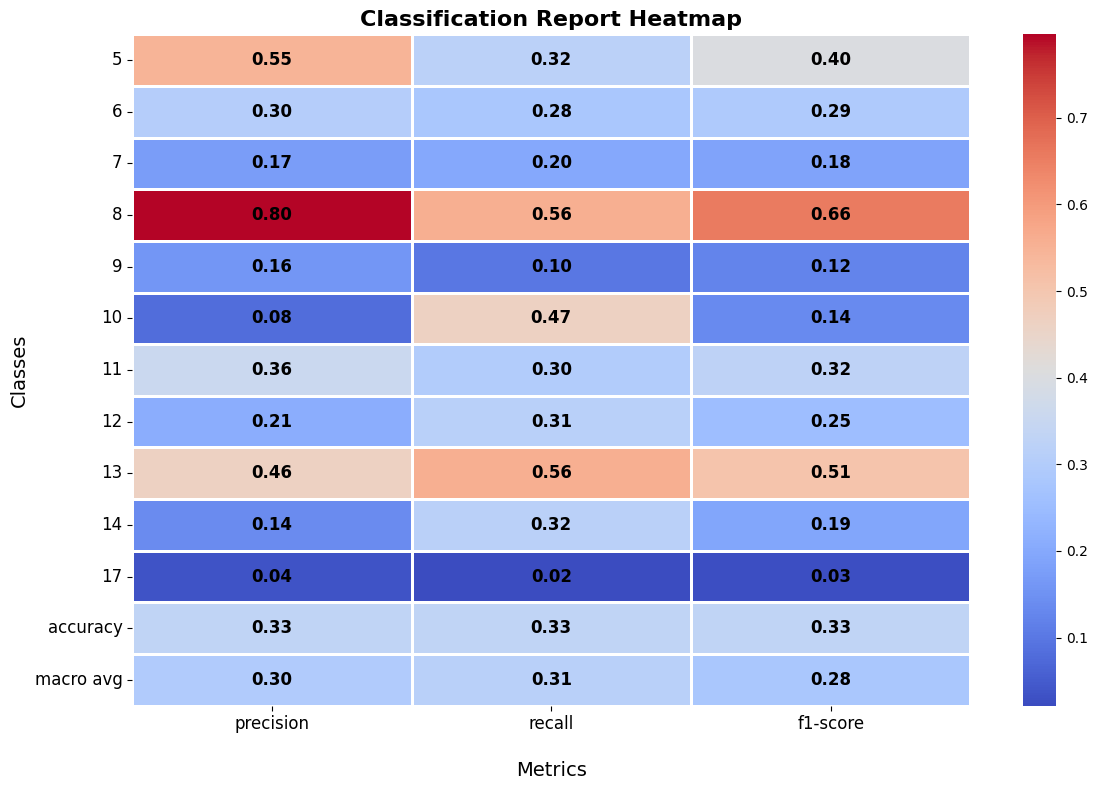

In [ ]:
plot_classification_report_heatmap(y_lca_test, y_lca_pred_dt, label_encoder_lca)

###### Visualization

In [ ]:
visualize_case(df_lca_test_dt, 1, 'Normal')

In [ ]:
# visualize_predictions(df_lca_test_dt)

##### **AdaBoost**

###### Training

In [ ]:
# Train AdaBoost classifier
print("Training AdaBoost Classifier on LCA...")
ab_lca = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_lca.fit(X_lca_train, y_lca_train)

# Make predictions on the test set
y_lca_pred_ab = ab_lca.predict(X_lca_test)

df_lca_test_ab = df_lca_test.copy()
df_lca_test_ab["prediction"] = label_encoder_lca.inverse_transform(y_lca_pred_ab)
df_lca_test_ab

Training AdaBoost Classifier on LCA...


,Px,Py,Pz,label,case,condition,prediction
0,105.460059,122.932732,105.9375,5,1,Normal,11
1,105.876075,123.348748,105.9375,5,1,Normal,11
2,106.292091,123.348748,106.5625,5,1,Normal,11
3,106.708107,123.348748,106.5625,5,1,Normal,11
4,107.124123,123.348748,107.1875,5,1,Normal,11
...,...,...,...,...,...,...,...
23172,169.787021,146.935470,117.8125,17,18,Diseased,9
23173,170.244052,146.935470,117.8125,17,18,Diseased,9
23174,170.701083,146.935470,117.1875,17,18,Diseased,9
23175,171.158114,147.392501,117.1875,17,18,Diseased,9


###### Classification Report

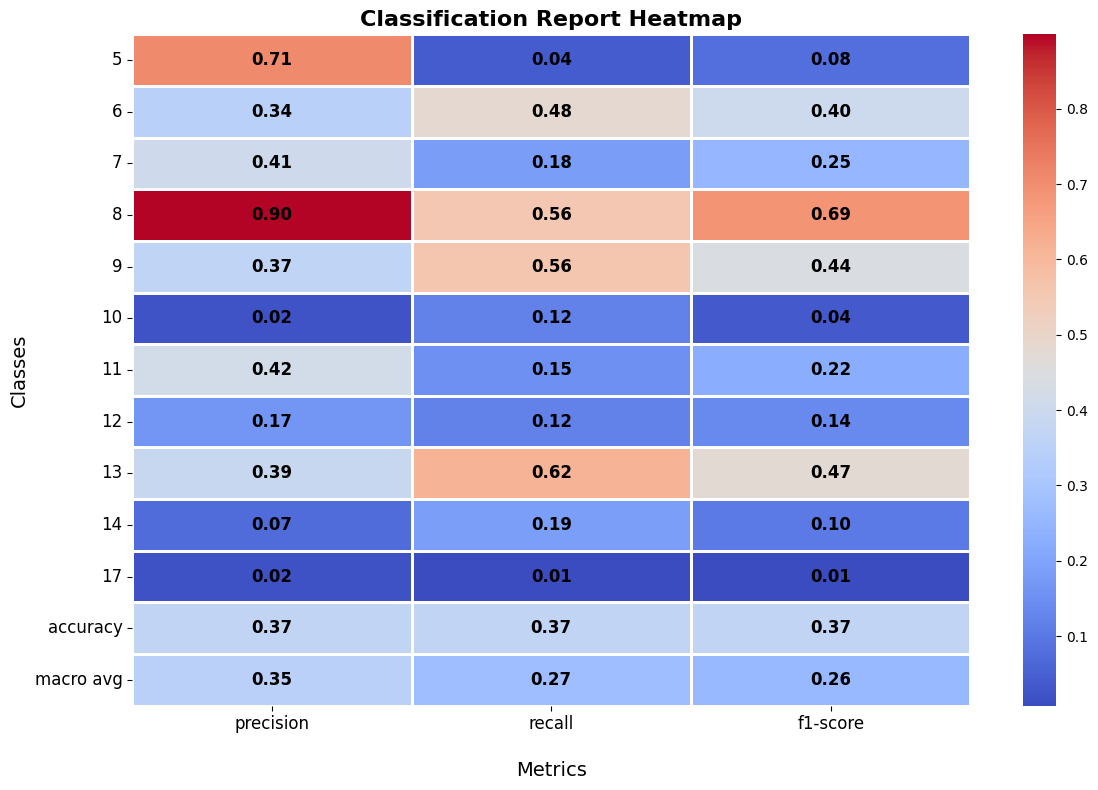

In [ ]:
plot_classification_report_heatmap(y_lca_test, y_lca_pred_ab, label_encoder_lca)

###### Visualization

In [ ]:
visualize_case(df_lca_test_ab, 1, 'Normal')

In [ ]:
# visualize_predictions(df_lca_test_ab)

##### **LightGBM**

###### Training

In [ ]:
# Train LightGBM classifier
print("Training LightGBM Classifier on LCA...")
lgb_lca = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_lca.fit(X_lca_train, y_lca_train)

# Make predictions on the test set
y_lca_pred_lgb = lgb_lca.predict(X_lca_test)

df_lca_test_lgb = df_lca_test.copy()
df_lca_test_lgb["prediction"] = label_encoder_lca.inverse_transform(y_lca_pred_lgb)
df_lca_test_lgb

Training LightGBM Classifier on LCA...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 17990, number of used features: 3
[LightGBM] [Info] Start training from score -3.184187
[LightGBM] [Info] Start training from score -2.509327
[LightGBM] [Info] Start training from score -2.232814
[LightGBM] [Info] Start training from score -1.707476
[LightGBM] [Info] Start training from score -2.408625
[LightGBM] [Info] Start training from score -2.667473
[LightGBM] [Info] Start training from score -2.671484
[LightGBM] [Info] Start training from score -2.683615
[LightGBM] [Info] Start training from score -1.736716
[LightGBM] [Info] Start training from score -2.615979
[LightGBM] [Info] Start training from score -3.153782


,Px,Py,Pz,label,case,condition,prediction
0,105.460059,122.932732,105.9375,5,1,Normal,11
1,105.876075,123.348748,105.9375,5,1,Normal,11
2,106.292091,123.348748,106.5625,5,1,Normal,11
3,106.708107,123.348748,106.5625,5,1,Normal,11
4,107.124123,123.348748,107.1875,5,1,Normal,11
...,...,...,...,...,...,...,...
23172,169.787021,146.935470,117.8125,17,18,Diseased,10
23173,170.244052,146.935470,117.8125,17,18,Diseased,10
23174,170.701083,146.935470,117.1875,17,18,Diseased,10
23175,171.158114,147.392501,117.1875,17,18,Diseased,10


###### Classification Report

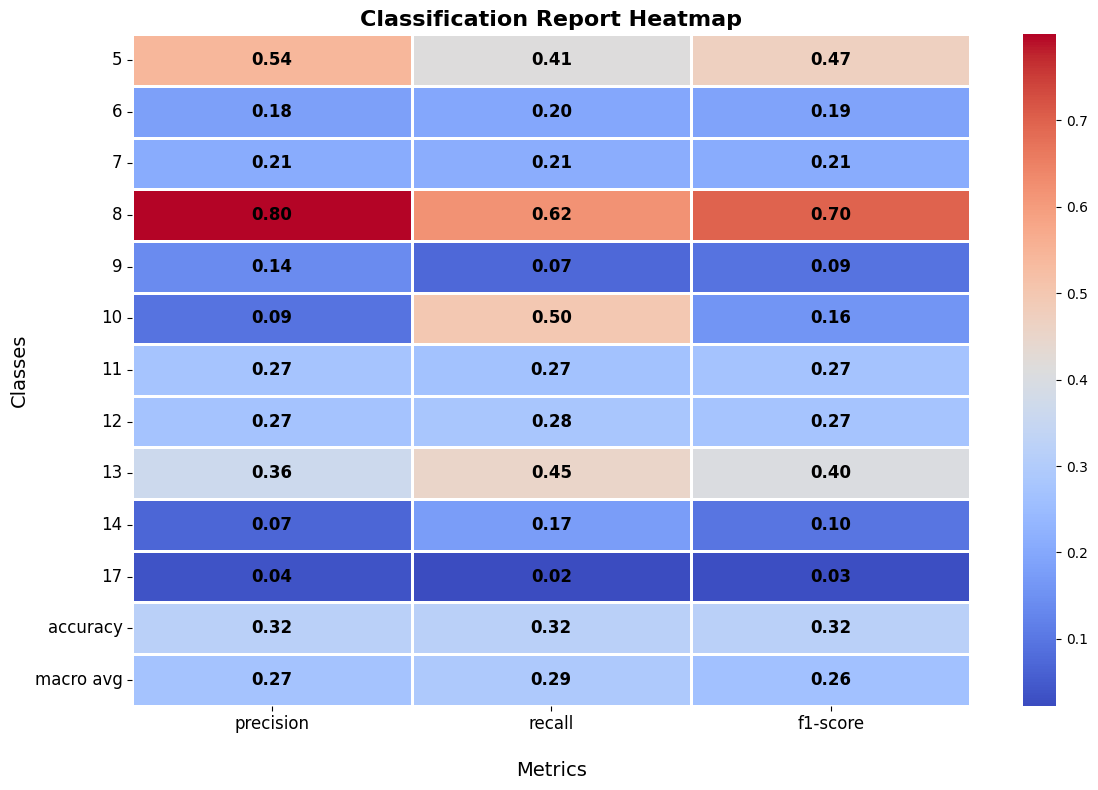

In [ ]:
plot_classification_report_heatmap(y_lca_test, y_lca_pred_lgb, label_encoder_lca)

###### Visualization

In [ ]:
visualize_case(df_lca_test_lgb, 1, 'Normal')

In [ ]:
# visualize_predictions(df_lca_test_lgb)

##### **CatBoost**

###### Training

In [ ]:
# Train CatBoost classifier
print("Training CatBoost Classifier on LCA...")
cb_lca = CatBoostClassifier(iterations=100, random_state=42, silent=True)
cb_lca.fit(X_lca_train, y_lca_train)

# Make predictions on the test set
y_lca_pred_cb = cb_lca.predict(X_lca_test)

df_lca_test_cb = df_lca_test.copy()
df_lca_test_cb["prediction"] = label_encoder_lca.inverse_transform(y_lca_pred_cb)
df_lca_test_cb

Training CatBoost Classifier on LCA...


,Px,Py,Pz,label,case,condition,prediction
0,105.460059,122.932732,105.9375,5,1,Normal,11
1,105.876075,123.348748,105.9375,5,1,Normal,5
2,106.292091,123.348748,106.5625,5,1,Normal,11
3,106.708107,123.348748,106.5625,5,1,Normal,11
4,107.124123,123.348748,107.1875,5,1,Normal,11
...,...,...,...,...,...,...,...
23172,169.787021,146.935470,117.8125,17,18,Diseased,9
23173,170.244052,146.935470,117.8125,17,18,Diseased,9
23174,170.701083,146.935470,117.1875,17,18,Diseased,9
23175,171.158114,147.392501,117.1875,17,18,Diseased,9


###### Classification Report

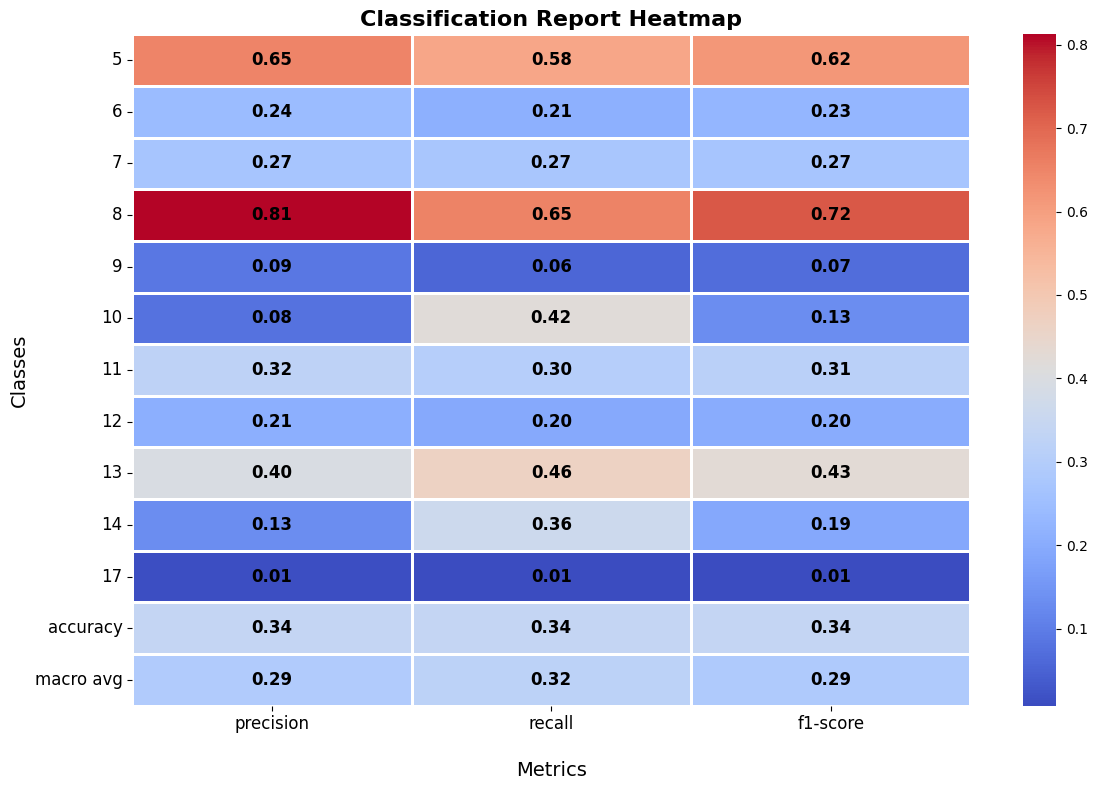

In [ ]:
plot_classification_report_heatmap(y_lca_test, y_lca_pred_cb, label_encoder_lca)

###### Visualization

In [ ]:
visualize_case(df_lca_test_lgb, 1, 'Normal')

In [ ]:
# visualize_predictions(df_lca_test_cb)

##### **HistGradientBoosting**

###### Training

In [ ]:
# Train HistGradientBoosting classifier
print("Training HistGradientBoosting Classifier on LCA...")
hgb_lca = HistGradientBoostingClassifier(max_iter=100, random_state=42)
hgb_lca.fit(X_lca_train, y_lca_train)

# Make predictions on the test set
y_lca_pred_hgb = hgb_lca.predict(X_lca_test)

df_lca_test_hgb = df_lca_test.copy()
df_lca_test_hgb["prediction"] = label_encoder_lca.inverse_transform(y_lca_pred_hgb)
df_lca_test_hgb

Training HistGradientBoosting Classifier on LCA...


,Px,Py,Pz,label,case,condition,prediction
0,105.460059,122.932732,105.9375,5,1,Normal,11
1,105.876075,123.348748,105.9375,5,1,Normal,11
2,106.292091,123.348748,106.5625,5,1,Normal,11
3,106.708107,123.348748,106.5625,5,1,Normal,11
4,107.124123,123.348748,107.1875,5,1,Normal,11
...,...,...,...,...,...,...,...
23172,169.787021,146.935470,117.8125,17,18,Diseased,7
23173,170.244052,146.935470,117.8125,17,18,Diseased,7
23174,170.701083,146.935470,117.1875,17,18,Diseased,7
23175,171.158114,147.392501,117.1875,17,18,Diseased,7


###### Classification Report

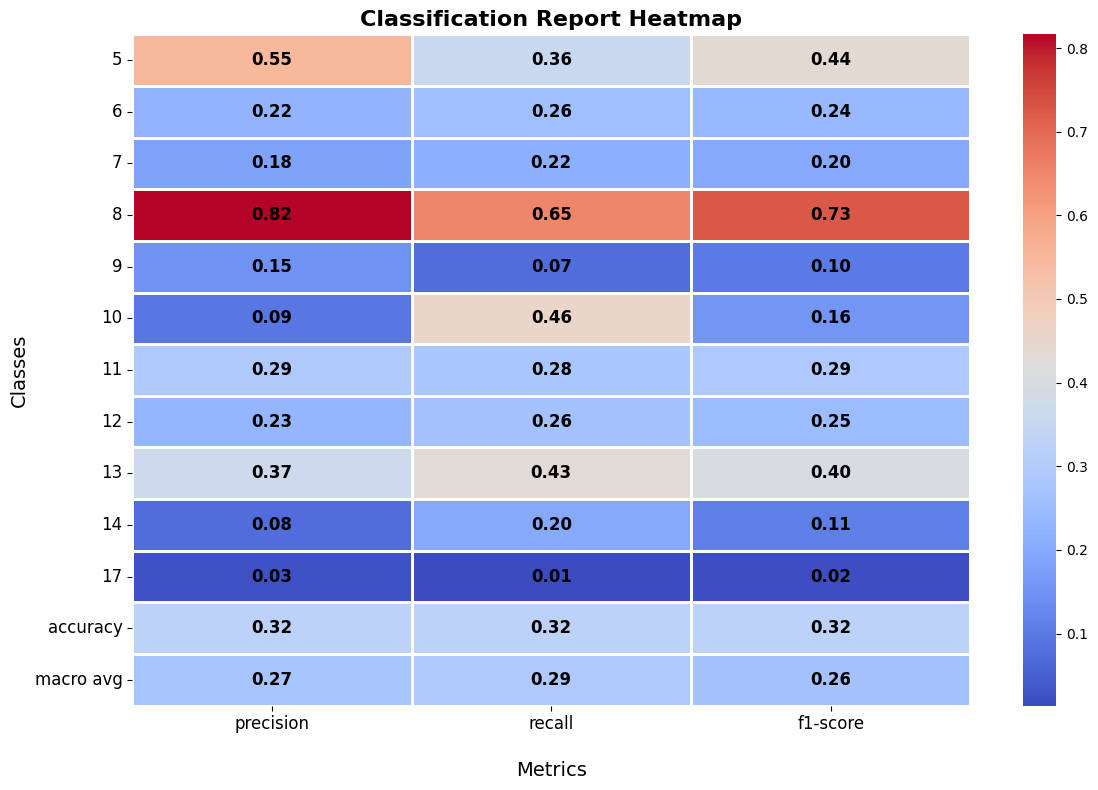

In [ ]:
plot_classification_report_heatmap(y_lca_test, y_lca_pred_hgb, label_encoder_lca)

###### Visualization

In [ ]:
visualize_case(df_lca_test_hgb, 1, 'Normal')

In [ ]:
# visualize_predictions(df_lca_test_hgb)

##### **Save and Load**

In [ ]:
# LCA - RandomForest
accuracy_rf_lca = save_simple_model(rf_lca, "RandomForest", "LCA", df_lca_test_rf, y_lca_test, y_lca_pred_rf, label_encoder_lca, path_saved)
model_rf_lca, df_preds_rf_lca, report_rf_lca, accuracy_rf_lca = load_simple_model("RandomForest", "LCA", path_saved)
print(report_rf_lca); print(f"Accuracy: {accuracy_rf_lca:.4f}")

# LCA - GradientBoosting
accuracy_gb_lca = save_simple_model(gb_lca, "GradientBoosting", "LCA", df_lca_test_gb, y_lca_test, y_lca_pred_gb, label_encoder_lca, path_saved)
model_gb_lca, df_preds_gb_lca, report_gb_lca, accuracy_gb_lca = load_simple_model("GradientBoosting", "LCA", path_saved)
print(report_gb_lca); print(f"Accuracy: {accuracy_gb_lca:.4f}")

# LCA - ExtraTrees
accuracy_et_lca = save_simple_model(et_lca, "ExtraTrees", "LCA", df_lca_test_et, y_lca_test, y_lca_pred_et, label_encoder_lca, path_saved)
model_et_lca, df_preds_et_lca, report_et_lca, accuracy_et_lca = load_simple_model("ExtraTrees", "LCA", path_saved)
print(report_et_lca); print(f"Accuracy: {accuracy_et_lca:.4f}")

# LCA - XGBoost
accuracy_xgb_lca = save_simple_model(xgb_lca, "XGBoost", "LCA", df_lca_test_xgb, y_lca_test, y_lca_pred_xgb, label_encoder_lca, path_saved)
model_xgb_lca, df_preds_xgb_lca, report_xgb_lca, accuracy_xgb_lca = load_simple_model("XGBoost", "LCA", path_saved)
print(report_xgb_lca); print(f"Accuracy: {accuracy_xgb_lca:.4f}")

# LCA - DecisionTree
accuracy_dt_lca = save_simple_model(dt_lca, "DecisionTree", "LCA", df_lca_test_dt, y_lca_test, y_lca_pred_dt, label_encoder_lca, path_saved)
model_dt_lca, df_preds_dt_lca, report_dt_lca, accuracy_dt_lca = load_simple_model("DecisionTree", "LCA", path_saved)
print(report_dt_lca); print(f"Accuracy: {accuracy_dt_lca:.4f}")

# LCA - AdaBoost
accuracy_ab_lca = save_simple_model(ab_lca, "AdaBoost", "LCA", df_lca_test_ab, y_lca_test, y_lca_pred_ab, label_encoder_lca, path_saved)
model_ab_lca, df_preds_ab_lca, report_ab_lca, accuracy_ab_lca = load_simple_model("AdaBoost", "LCA", path_saved)
print(report_ab_lca); print(f"Accuracy: {accuracy_ab_lca:.4f}")

# LCA - LightGBM
accuracy_lgb_lca = save_simple_model(lgb_lca, "LightGBM", "LCA", df_lca_test_lgb, y_lca_test, y_lca_pred_lgb, label_encoder_lca, path_saved)
model_lgb_lca, df_preds_lgb_lca, report_lgb_lca, accuracy_lgb_lca = load_simple_model("LightGBM", "LCA", path_saved)
print(report_lgb_lca); print(f"Accuracy: {accuracy_lgb_lca:.4f}")

# LCA - CatBoost
accuracy_cb_lca = save_simple_model(cb_lca, "CatBoost", "LCA", df_lca_test_cb, y_lca_test, y_lca_pred_cb, label_encoder_lca, path_saved)
model_cb_lca, df_preds_cb_lca, report_cb_lca, accuracy_cb_lca = load_simple_model("CatBoost", "LCA", path_saved)
print(report_cb_lca); print(f"Accuracy: {accuracy_cb_lca:.4f}")

# LCA - HistGradientBoosting
accuracy_hgb_lca = save_simple_model(hgb_lca, "HistGradientBoosting", "LCA", df_lca_test_hgb, y_lca_test, y_lca_pred_hgb, label_encoder_lca, path_saved)
model_hgb_lca, df_preds_hgb_lca, report_hgb_lca, accuracy_hgb_lca = load_simple_model("HistGradientBoosting", "LCA", path_saved)
print(report_hgb_lca); print(f"Accuracy: {accuracy_hgb_lca:.4f}")

✅ Saved model, predictions, report, and accuracy for RandomForest - LCA
✅ Loaded model, predictions, report, and accuracy for RandomForest - LCA
              precision    recall  f1-score   support

           5       0.59      0.58      0.59       402
           6       0.22      0.23      0.22       675
           7       0.19      0.18      0.18       696
           8       0.84      0.64      0.73      1567
           9       0.10      0.06      0.08      1015
          10       0.11      0.65      0.19       133
          11       0.34      0.31      0.33       656
          12       0.37      0.29      0.32       461
          13       0.41      0.52      0.46      1026
          14       0.11      0.32      0.17       189
          17       0.02      0.01      0.02       659

    accuracy                           0.35      7479
   macro avg       0.30      0.35      0.30      7479
weighted avg       0.38      0.35      0.35      7479

Accuracy: 0.3492
✅ Saved model, prediction

## **Non Tree-based Machine Learning Models**

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Perceptron": Perceptron(random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "SVM": SVC(kernel='rbf', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    # "Gaussian Process Classifier": GaussianProcessClassifier(random_state=42),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42)
}

#### **RCA labeling**

In [ ]:
# saved_dfs = {}

# for name, model in models.items():
#     print(f"Training {name}...")
#     model.fit(X_rca_train, y_rca_train)
#     y_pred = model.predict(X_rca_test)
#     print(f"Classification Report for {name}:")
#     plot_classification_report_heatmap(y_rca_test, y_pred, label_encoder_rca)

#     df_rca_test_model = df_rca_test.copy()
#     df_rca_test_model["prediction"] = label_encoder_rca.inverse_transform(y_pred)

#     saved_dfs[name] = df_rca_test_model

In [ ]:
# for name, model in models.items():
#   print(f"Visualization for {name}:")
#   visualize_case(saved_dfs[name], 1, 'Normal')

In [ ]:
# RCA - Save
accuracy_list = []

for name, model in models.items():
    print(f"Training {name} on RCA...")
    model.fit(X_rca_train, y_rca_train)
    y_pred = model.predict(X_rca_test)

    df_rca_test_model = df_rca_test.copy()
    df_rca_test_model["prediction"] = label_encoder_rca.inverse_transform(y_pred)

    accuracy = save_simple_model(
        model=model,
        model_name=name.replace(" ", "_"),
        artery_type="RCA",
        df_test=df_rca_test_model,
        y_true=y_rca_test,
        y_pred=y_pred,
        label_encoder=label_encoder_rca,
        base_path=path_saved
    )

    accuracy_list.append({"Model": name, "Artery": "RCA", "Accuracy": accuracy})

# RCA - Load
model_logreg, df_preds_logreg, report_logreg, accuracy_logreg = load_simple_model("Logistic_Regression", "RCA", path_saved)
print(report_logreg); print(f"Accuracy: {accuracy_logreg:.4f}")

model_perceptron, df_preds_perceptron, report_perceptron, accuracy_perceptron = load_simple_model("Perceptron", "RCA", path_saved)
print(report_perceptron); print(f"Accuracy: {accuracy_perceptron:.4f}")

model_ridge, df_preds_ridge, report_ridge, accuracy_ridge = load_simple_model("Ridge_Classifier", "RCA", path_saved)
print(report_ridge); print(f"Accuracy: {accuracy_ridge:.4f}")

model_svm, df_preds_svm, report_svm, accuracy_svm = load_simple_model("SVM", "RCA", path_saved)
print(report_svm); print(f"Accuracy: {accuracy_svm:.4f}")

model_knn, df_preds_knn, report_knn, accuracy_knn = load_simple_model("KNN", "RCA", path_saved)
print(report_knn); print(f"Accuracy: {accuracy_knn:.4f}")

model_nb, df_preds_nb, report_nb, accuracy_nb = load_simple_model("Naive_Bayes", "RCA", path_saved)
print(report_nb); print(f"Accuracy: {accuracy_nb:.4f}")

model_lda, df_preds_lda, report_lda, accuracy_lda = load_simple_model("LDA", "RCA", path_saved)
print(report_lda); print(f"Accuracy: {accuracy_lda:.4f}")

model_qda, df_preds_qda, report_qda, accuracy_qda = load_simple_model("QDA", "RCA", path_saved)
print(report_qda); print(f"Accuracy: {accuracy_qda:.4f}")

model_mlp, df_preds_mlp, report_mlp, accuracy_mlp = load_simple_model("MLP_Classifier", "RCA", path_saved)
print(report_mlp); print(f"Accuracy: {accuracy_mlp:.4f}")

Training Logistic Regression on RCA...
✅ Saved model, predictions, report, and accuracy for Logistic_Regression - RCA
Training Perceptron on RCA...
✅ Saved model, predictions, report, and accuracy for Perceptron - RCA
Training Ridge Classifier on RCA...
✅ Saved model, predictions, report, and accuracy for Ridge_Classifier - RCA
Training SVM on RCA...
✅ Saved model, predictions, report, and accuracy for SVM - RCA
Training KNN on RCA...
✅ Saved model, predictions, report, and accuracy for KNN - RCA
Training Naive Bayes on RCA...
✅ Saved model, predictions, report, and accuracy for Naive_Bayes - RCA
Training LDA on RCA...
✅ Saved model, predictions, report, and accuracy for LDA - RCA
Training QDA on RCA...
✅ Saved model, predictions, report, and accuracy for QDA - RCA
Training MLP Classifier on RCA...
✅ Saved model, predictions, report, and accuracy for MLP_Classifier - RCA
✅ Loaded model, predictions, report, and accuracy for Logistic_Regression - RCA
              precision    recall  f

#### **LCA labeling**

In [ ]:
# saved_dfs_lca = {}

# for name, model in models.items():
#   print(f"Training {name}...")
#   model.fit(X_lca_train, y_lca_train)
#   y_pred = model.predict(X_lca_test)
#   print(f"Classification Report for {name}:")
#   plot_classification_report_heatmap(y_lca_test, y_pred, label_encoder_lca)

#   df_lca_test_model = df_lca_test.copy()
#   df_lca_test_model["prediction"] = label_encoder_lca.inverse_transform(y_pred)

#   saved_dfs_lca[name] = df_lca_test_model

In [ ]:
# for name, model in models.items():
#   print(f"Visualization for {name}:")
#   visualize_case(saved_dfs_lca[name], 1, 'Normal')

In [ ]:
# LCA - Save
for name, model in models.items():
    print(f"Training {name} on LCA...")
    model.fit(X_lca_train, y_lca_train)
    y_pred = model.predict(X_lca_test)

    df_lca_test_model = df_lca_test.copy()
    df_lca_test_model["prediction"] = label_encoder_lca.inverse_transform(y_pred)

    accuracy = save_simple_model(
        model=model,
        model_name=name.replace(" ", "_"),
        artery_type="LCA",
        df_test=df_lca_test_model,
        y_true=y_lca_test,
        y_pred=y_pred,
        label_encoder=label_encoder_lca,
        base_path=path_saved
    )

    accuracy_list.append({"Model": name, "Artery": "LCA", "Accuracy": accuracy})

# LCA - Load
model_logreg_lca, df_preds_logreg_lca, report_logreg_lca, accuracy_logreg_lca = load_simple_model("Logistic_Regression", "LCA", path_saved)
print(report_logreg_lca); print(f"Accuracy: {accuracy_logreg_lca:.4f}")

model_perceptron_lca, df_preds_perceptron_lca, report_perceptron_lca, accuracy_perceptron_lca = load_simple_model("Perceptron", "LCA", path_saved)
print(report_perceptron_lca); print(f"Accuracy: {accuracy_perceptron_lca:.4f}")

model_ridge_lca, df_preds_ridge_lca, report_ridge_lca, accuracy_ridge_lca = load_simple_model("Ridge_Classifier", "LCA", path_saved)
print(report_ridge_lca); print(f"Accuracy: {accuracy_ridge_lca:.4f}")

model_svm_lca, df_preds_svm_lca, report_svm_lca, accuracy_svm_lca = load_simple_model("SVM", "LCA", path_saved)
print(report_svm_lca); print(f"Accuracy: {accuracy_svm_lca:.4f}")

model_knn_lca, df_preds_knn_lca, report_knn_lca, accuracy_knn_lca = load_simple_model("KNN", "LCA", path_saved)
print(report_knn_lca); print(f"Accuracy: {accuracy_knn_lca:.4f}")

model_nb_lca, df_preds_nb_lca, report_nb_lca, accuracy_nb_lca = load_simple_model("Naive_Bayes", "LCA", path_saved)
print(report_nb_lca); print(f"Accuracy: {accuracy_nb_lca:.4f}")

model_lda_lca, df_preds_lda_lca, report_lda_lca, accuracy_lda_lca = load_simple_model("LDA", "LCA", path_saved)
print(report_lda_lca); print(f"Accuracy: {accuracy_lda_lca:.4f}")

model_qda_lca, df_preds_qda_lca, report_qda_lca, accuracy_qda_lca = load_simple_model("QDA", "LCA", path_saved)
print(report_qda_lca); print(f"Accuracy: {accuracy_qda_lca:.4f}")

model_mlp_lca, df_preds_mlp_lca, report_mlp_lca, accuracy_mlp_lca = load_simple_model("MLP_Classifier", "LCA", path_saved)
print(report_mlp_lca); print(f"Accuracy: {accuracy_mlp_lca:.4f}")

Training Logistic Regression on LCA...
✅ Saved model, predictions, report, and accuracy for Logistic_Regression - LCA
Training Perceptron on LCA...
✅ Saved model, predictions, report, and accuracy for Perceptron - LCA
Training Ridge Classifier on LCA...
✅ Saved model, predictions, report, and accuracy for Ridge_Classifier - LCA
Training SVM on LCA...
✅ Saved model, predictions, report, and accuracy for SVM - LCA
Training KNN on LCA...
✅ Saved model, predictions, report, and accuracy for KNN - LCA
Training Naive Bayes on LCA...
✅ Saved model, predictions, report, and accuracy for Naive_Bayes - LCA
Training LDA on LCA...
✅ Saved model, predictions, report, and accuracy for LDA - LCA
Training QDA on LCA...
✅ Saved model, predictions, report, and accuracy for QDA - LCA
Training MLP Classifier on LCA...
✅ Saved model, predictions, report, and accuracy for MLP_Classifier - LCA
✅ Loaded model, predictions, report, and accuracy for Logistic_Regression - LCA
              precision    recall  f

### **Visualization**

In [ ]:
SEGMENT_COLORS = {
    1: '#006400',   # pRCA → dark green
    2: '#FFFF00',   # mRCA → yellow
    3: '#8B4513',   # dRCA → brown
    4: '#0000FF',   # R-PDA → blue
    5: '#FF0000',   # LM → red
    6: '#FFA500',   # pLAD → orange
    7: '#6B8E23',   # mLAD → olive drab (apagado, terroso)
    8: '#A52A2A',   # dLAD → reddish brown
    9: '#7CFC00',   # D1 → lime green / neon green
    10: '#2F1B0C',  # D2 → very dark brown
    11: '#F5F5DC',  # pLCx → beige
    12: '#DFFF00',  # OM1 → lemon/lime yellow
    13: '#C8A2C8',  # LCx → lilac
    14: '#FFFFE0',  # OM2 → very light yellow
    15: '#DAA520',  # L-PDA → goldenrod
    16: '#CCFF00',  # R-PLB → phosphorescent yellow
    17: '#00008B',  # RI → dark blue
    18: '#B22222',  # L-PLB → firebrick red
    19: '#FF4500'   # tertiary → reddish orange
}


In [ ]:
# nova funció per a visualitzar true y pred però amb colors que toquen
def visualize_case(df, case, condition):
    """
    Visualizes the segmented branches of the artery for a specific case and condition using a 3D scatter plot.
    Both the true labels and predicted labels are visualized using the defined color scheme and names.
    """
    branch_name_map = {
        1: "1 - pRCA", 2: "2 - mRCA", 3: "3 - dRCA", 4: "4 - R-PDA", 5: "5 - LM",
        6: "6 - pLAD", 7: "7 - mLAD", 8: "8 - dLAD", 9: "9 - D1", 10: "10 - D2",
        11: "11 - pLCx", 12: "12 - OM1", 13: "13 - LCx", 14: "14 - OM2", 15: "15 - L-PDA",
        16: "16 - R-PLB", 17: "17 - RI", 18: "18 - L-PLB"
    }

    case_condition_data = df[(df['case'] == case) & (df['condition'] == condition)]

    if case_condition_data.empty:
        print(f"No data found for case {case} and condition {condition}.")
        return

    fig = go.Figure()

    # Plot true labels
    for label in case_condition_data['label'].unique():
        label_data = case_condition_data[case_condition_data['label'] == label]
        color = SEGMENT_COLORS.get(label, 'grey')
        name = branch_name_map.get(label, f'True Label {label}')
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=4, color=color, opacity=0.8),
            name=f"True: {name}"
        ))

    # Plot predicted labels
    for label in case_condition_data['prediction'].unique():
        label_data = case_condition_data[case_condition_data['prediction'] == label]
        color = SEGMENT_COLORS.get(label, 'grey')
        name = branch_name_map.get(label, f'Predicted Label {label}')
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=4, color=color, opacity=0.8),
            name=f"Pred: {name}"
        ))

    fig.update_layout(
        title=f'Predictions vs True Labels for Case {case} ({condition})',
        scene=dict(
            xaxis=dict(title='Px', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            yaxis=dict(title='Py', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            zaxis=dict(title='Pz', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            aspectmode='data'
        ),
        margin=dict(l=10, r=10, b=10, t=50),
        height=800,
        showlegend=True
    )

    fig.show()


In [ ]:
# funció per eliminar true y pred llegenda
def visualize_case(df, case, condition):
    """
    Visualizes the segmented branches of the artery for a specific case and condition using a 3D scatter plot.
    Both true and predicted labels are shown using segment names only, with same color but different opacities.
    """
    branch_name_map = {
        1: "1 - pRCA", 2: "2 - mRCA", 3: "3 - dRCA", 4: "4 - R-PDA", 5: "5 - LM",
        6: "6 - pLAD", 7: "7 - mLAD", 8: "8 - dLAD", 9: "9 - D1", 10: "10 - D2",
        11: "11 - pLCx", 12: "12 - OM1", 13: "13 - LCx", 14: "14 - OM2", 15: "15 - L-PDA",
        16: "16 - R-PLB", 17: "17 - RI", 18: "18 - L-PLB"
    }

    case_condition_data = df[(df['case'] == case) & (df['condition'] == condition)]

    if case_condition_data.empty:
        print(f"No data found for case {case} and condition {condition}.")
        return

    fig = go.Figure()

    # Etiquetas verdaderas
    for label in case_condition_data['label'].unique():
        label_data = case_condition_data[case_condition_data['label'] == label]
        color = SEGMENT_COLORS.get(label, 'grey')
        name = branch_name_map.get(label, str(label))
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=12, color=color, opacity=0.8),
            name=name
        ))

    # Etiquetas predichas
    for label in case_condition_data['prediction'].unique():
        label_data = case_condition_data[case_condition_data['prediction'] == label]
        color = SEGMENT_COLORS.get(label, 'grey')
        name = branch_name_map.get(label, str(label))
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=12, color=color, opacity=0.8),
            name=name
        ))

    fig.update_layout(
        title=f'Segment Labels for Case {case} ({condition})',
        scene=dict(
            xaxis=dict(title='Px', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            yaxis=dict(title='Py', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            zaxis=dict(title='Pz', backgroundcolor='white', gridcolor='lightgrey', showbackground=True),
            aspectmode='data'
        ),
        margin=dict(l=10, r=10, b=10, t=50),
        height=800,
        showlegend=True
    )

    fig.show()


In [ ]:
# no fondo
def visualize_case(df, case, condition):
    """
    Visualizes the segmented branches of the artery for a specific case and condition using a 3D scatter plot.
    The plot has a clean white background and no visible axes or grid.
    """
    branch_name_map = {
        1: "1 - pRCA", 2: "2 - mRCA", 3: "3 - dRCA", 4: "4 - R-PDA", 5: "5 - LM",
        6: "6 - pLAD", 7: "7 - mLAD", 8: "8 - dLAD", 9: "9 - D1", 10: "10 - D2",
        11: "11 - pLCx", 12: "12 - OM1", 13: "13 - LCx", 14: "14 - OM2", 15: "15 - L-PDA",
        16: "16 - R-PLB", 17: "17 - RI", 18: "18 - L-PLB"
    }

    case_condition_data = df[(df['case'] == case) & (df['condition'] == condition)]

    if case_condition_data.empty:
        print(f"No data found for case {case} and condition {condition}.")
        return

    fig = go.Figure()

    # Plot true labels
    for label in case_condition_data['label'].unique():
        label_data = case_condition_data[case_condition_data['label'] == label]
        color = SEGMENT_COLORS.get(label, 'grey')
        name = branch_name_map.get(label, f'True Label {label}')
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=4, color=color, opacity=0.8),
            name=f"True: {name}"
        ))

    # Plot predicted labels
    for label in case_condition_data['prediction'].unique():
        label_data = case_condition_data[case_condition_data['prediction'] == label]
        color = SEGMENT_COLORS.get(label, 'grey')
        name = branch_name_map.get(label, f'Predicted Label {label}')
        fig.add_trace(go.Scatter3d(
            x=label_data['Px'],
            y=label_data['Py'],
            z=label_data['Pz'],
            mode='markers',
            marker=dict(size=4, color=color, opacity=0.8),
            name=f"Pred: {name}"
        ))

    fig.update_layout(
        title=f'Predictions vs True Labels for Case {case} ({condition})',
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            bgcolor='white'
        ),
        paper_bgcolor='white',
        plot_bgcolor='white',
        margin=dict(l=10, r=10, b=10, t=50),
        height=800,
        showlegend=True
    )

    fig.show()


In [ ]:
# model_svm_rca, df_preds_svm_rca, report_svm_rca, accuracy_svm_rca = load_simple_model("SVM", "RCA", path_saved)
model_lg_lca, df_preds_lg_lca, report_lg_lca, accuracy_lg_lca = load_simple_model("Logistic_Regression", "RCA", path_saved)

✅ Loaded model, predictions, report, and accuracy for Logistic_Regression - RCA


In [ ]:
# visualize_case(df_preds_svm, 16, "Normal")

In [ ]:
visualize_case(df_preds_lg_lca, 9, "Diseased")